In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots,\
                       plot_joint_feature_dependence
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [5]:
def load(focus_class):
    with open(f'explanations/clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           categorical_features=categorical_features,
                           feature_precisions=feature_precisions, state=state)
    return node

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 101it [00:12,  1.98it/s]                        
Permutation explainer: 101it [00:11,  1.15it/s]                        


CPU times: user 1min 1s, sys: 3.49 s, total: 1min 4s
Wall time: 23.5 s


In [7]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'explanations/clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(False, False)
(False, True)
(True, False)
(True, True)
CPU times: user 7h 59min, sys: 35min 57s, total: 8h 34min 57s
Wall time: 2h 51min 51s


# Individual Explanations

In [147]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [148]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

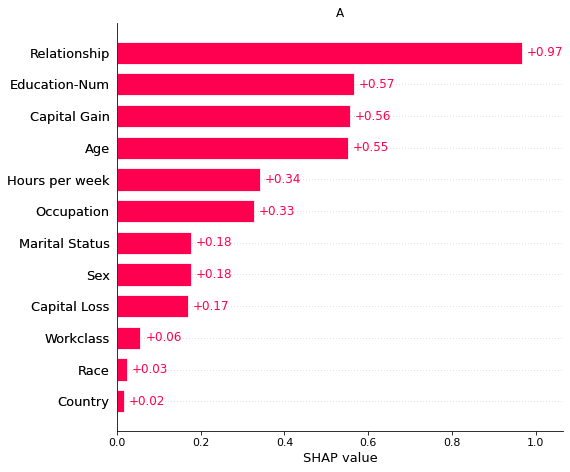

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

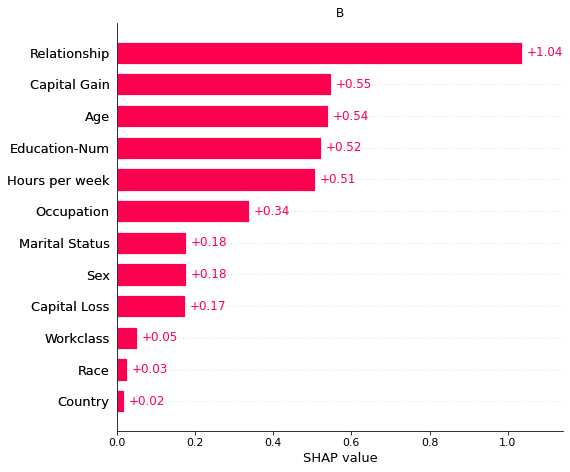

In [10]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

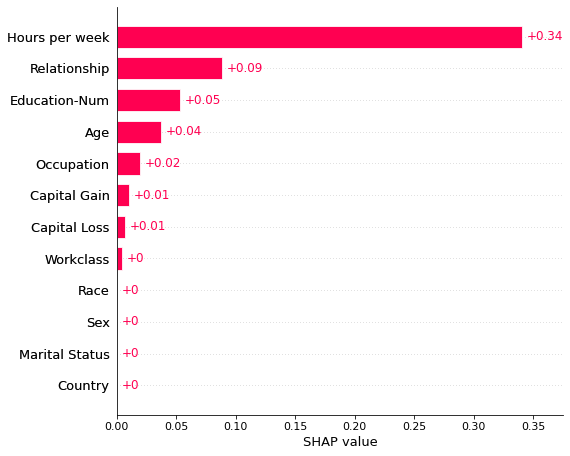

In [138]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'] - indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, feature_order=feature_order)
plt.savefig('figures/adult-diff-feat-imp.pdf', bbox_inches='tight')

In [11]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 890 ms, sys: 51.2 ms, total: 942 ms
Wall time: 525 ms


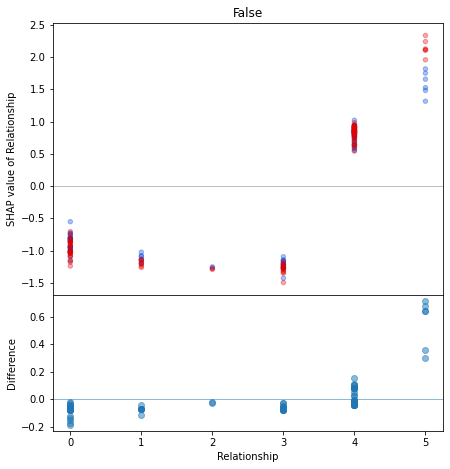

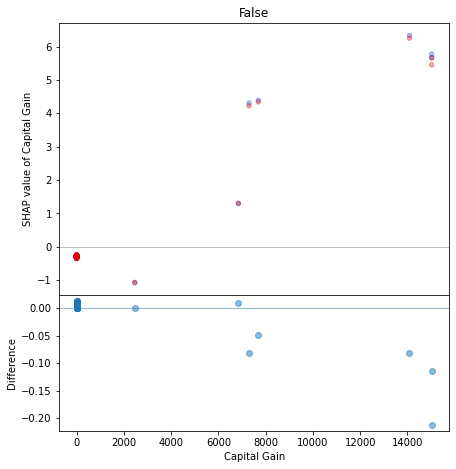

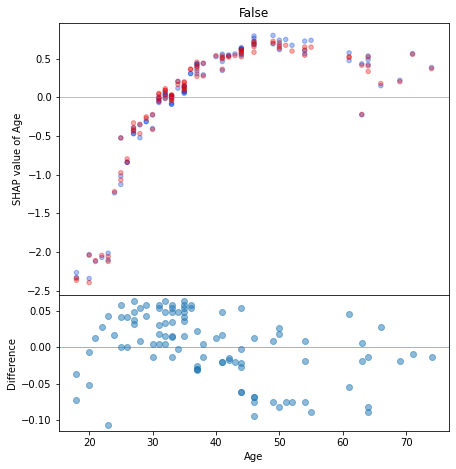

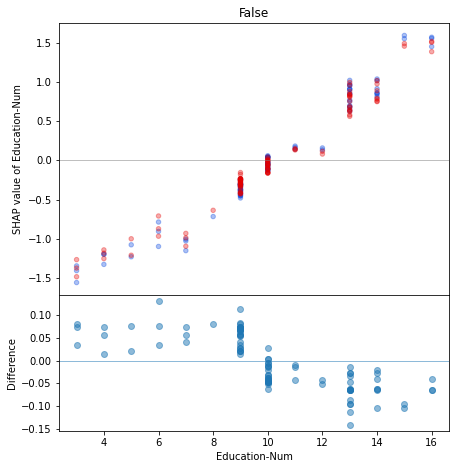

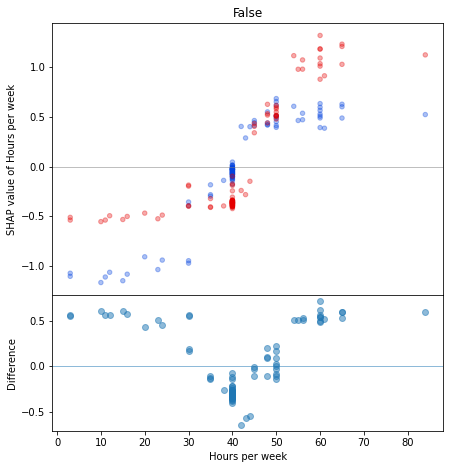

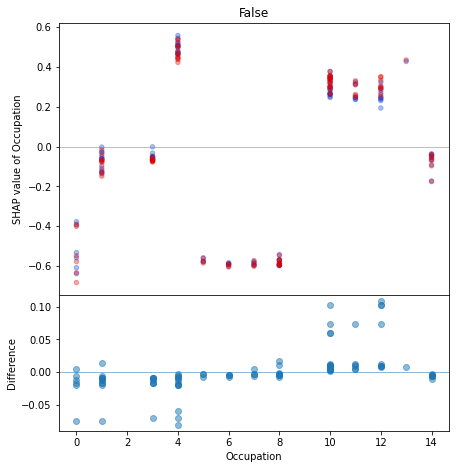

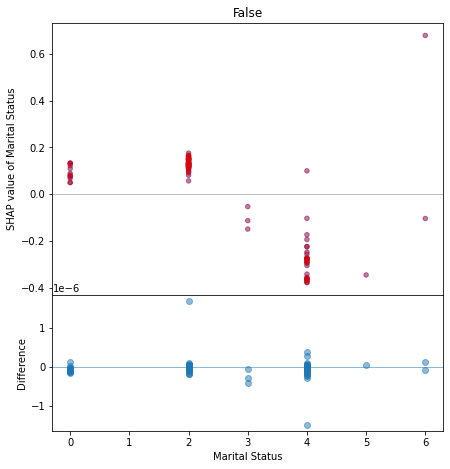

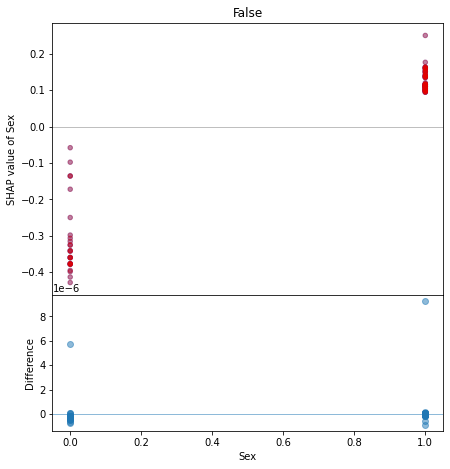

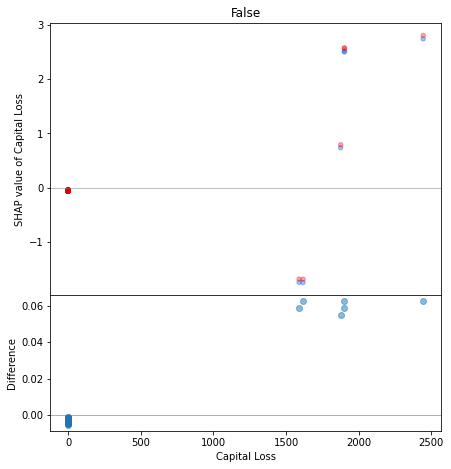

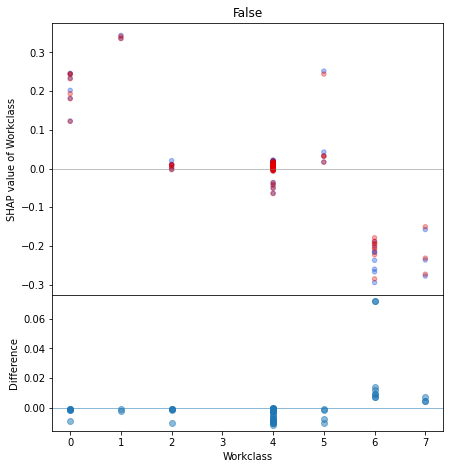

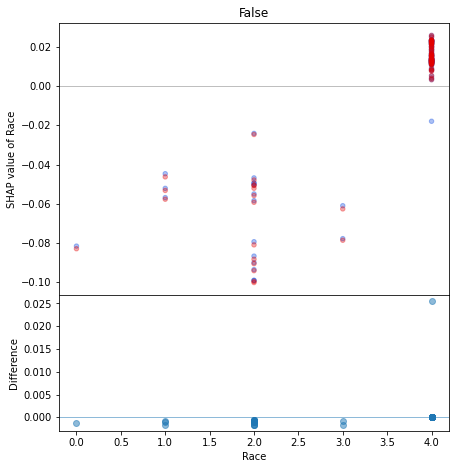

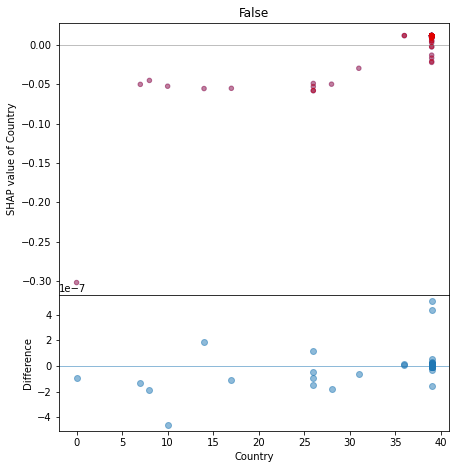

In [43]:
compare_indiv_dep_plots(node)

# Difference Classifier Explanations

In [26]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

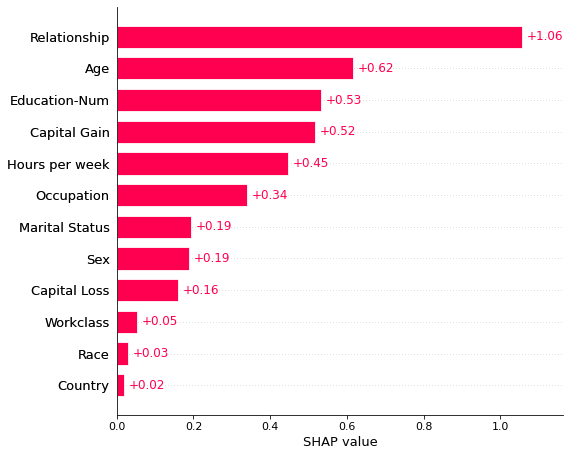

In [27]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## Clustering of Class $(True, False)$ SHAP Values

In [28]:
node = load('(True, False)')
node.class_counts, node.distance

((False, False)    78
 (True, True)      17
 (True, False)      5
 dtype: int64,
 281.1685447247144)

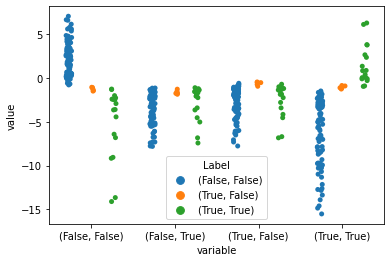

In [29]:
node.plot_outcomes()

### Main Node (RL)

In [62]:
node = node.root.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RL,
 (False, False)    33
 (True, True)      12
 (True, False)      5
 dtype: int64,
 79.28268292947294)

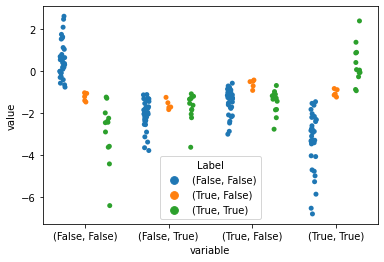

In [31]:
node.plot_outcomes()

In [63]:
print(node.rule_from_counterfactuals()[0])

`Education-Num` > 8 and Age > 26 and 34 < `Hours per week` <= 54 and `Capital Gain` <= 56


Relationship <= 4.0
[]


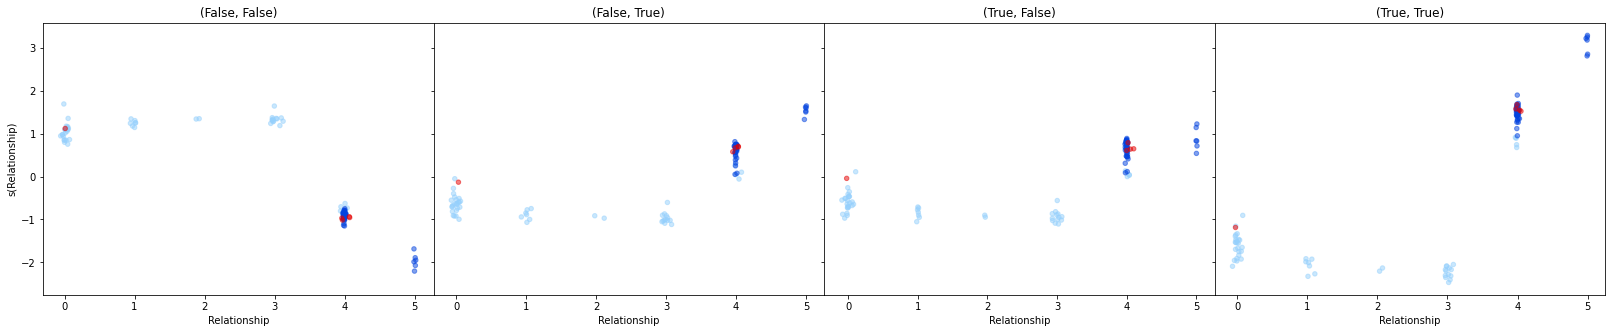

10.0 <= Education-Num <= 13.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 5}]


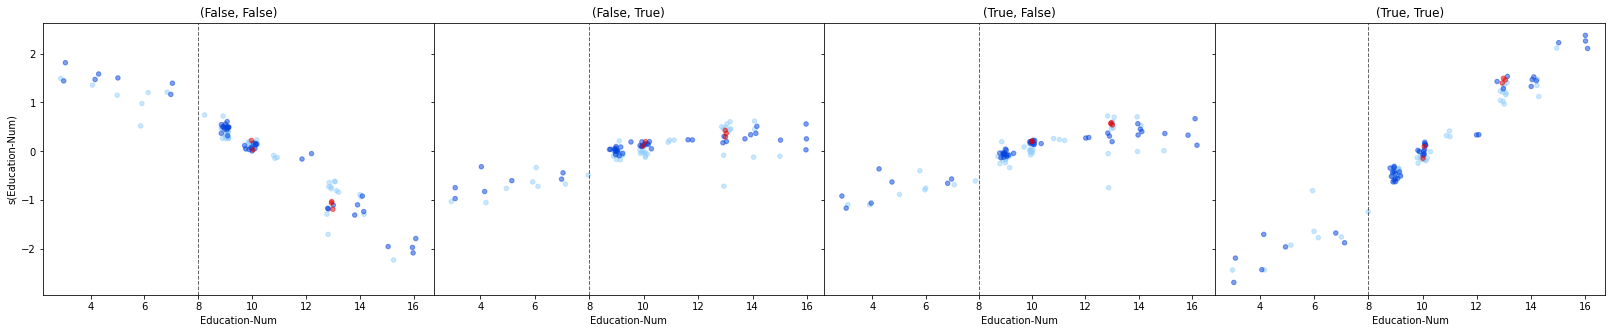

32.0 <= Age <= 50.0
[Lower CF: Age == 26.0 --> {'(False, False)': 5}]


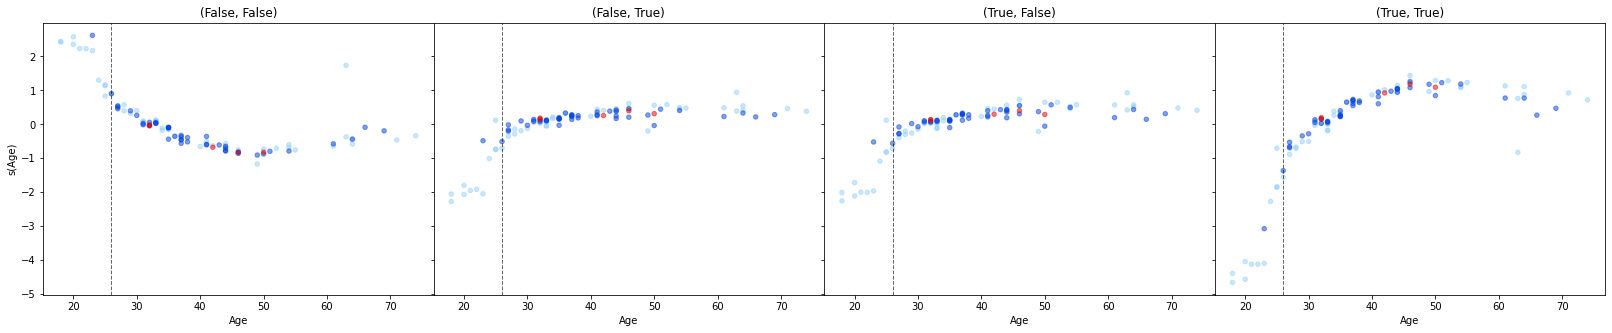

40.0 <= Hours per week <= 48.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 5},
 Upper CF: Hours per week == 55.0 --> {'(True, True)': 5}]


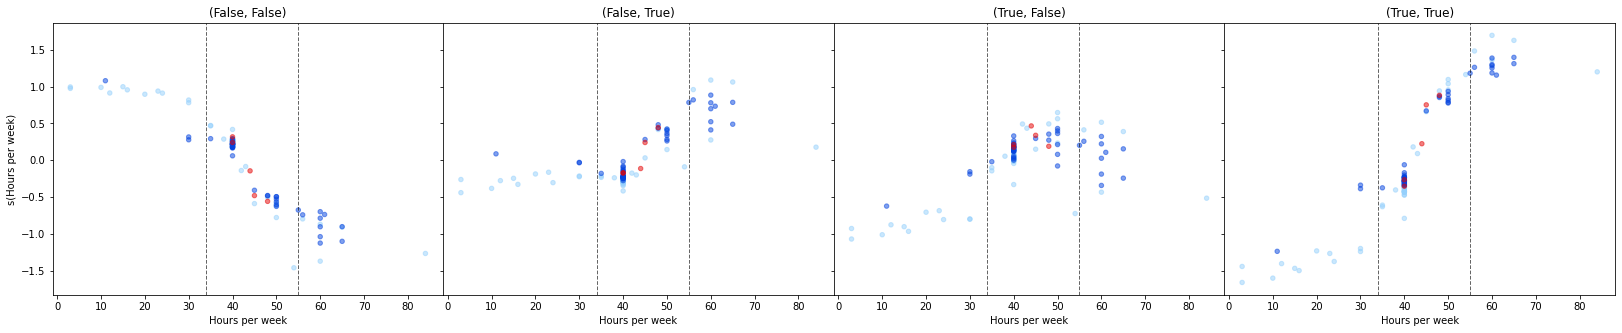

4.0 <= Occupation
[]


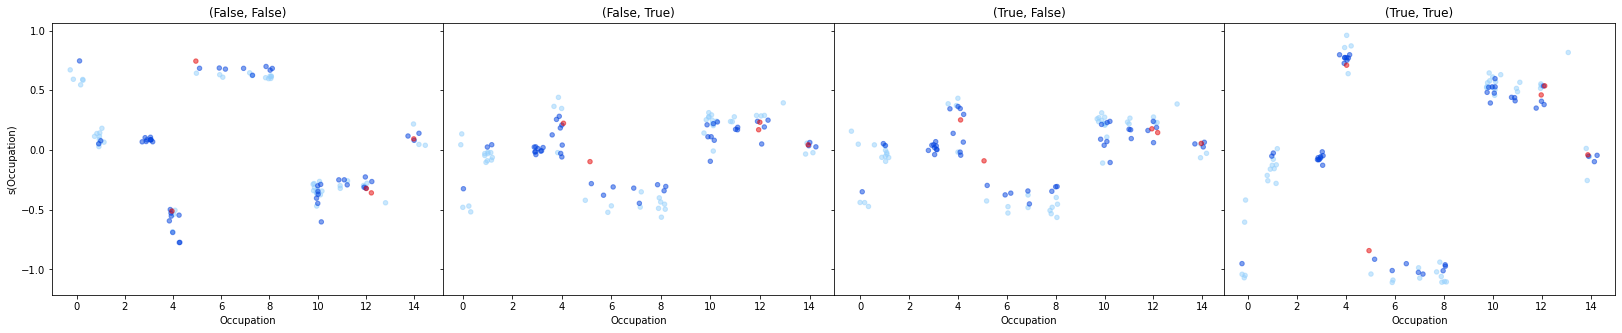

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 5}]


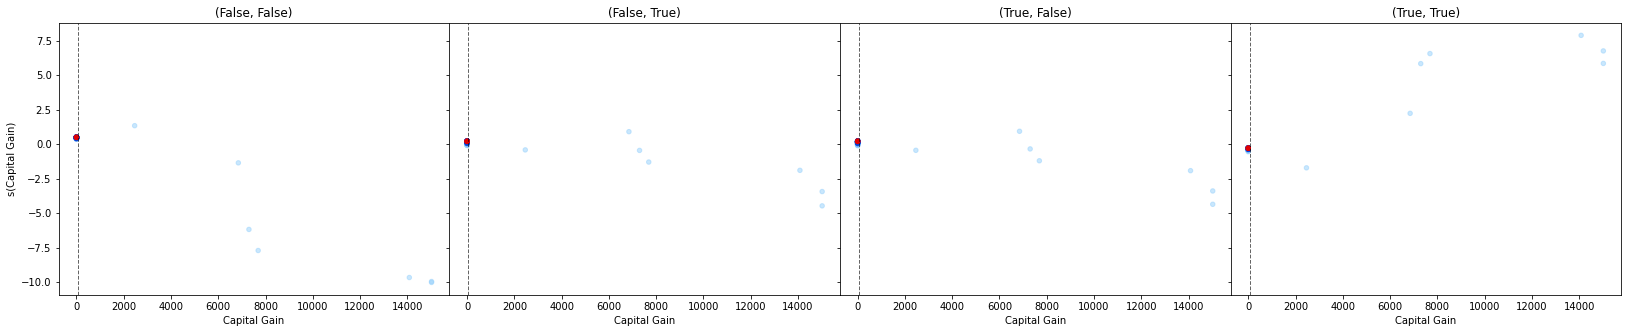

Capital Loss
[]


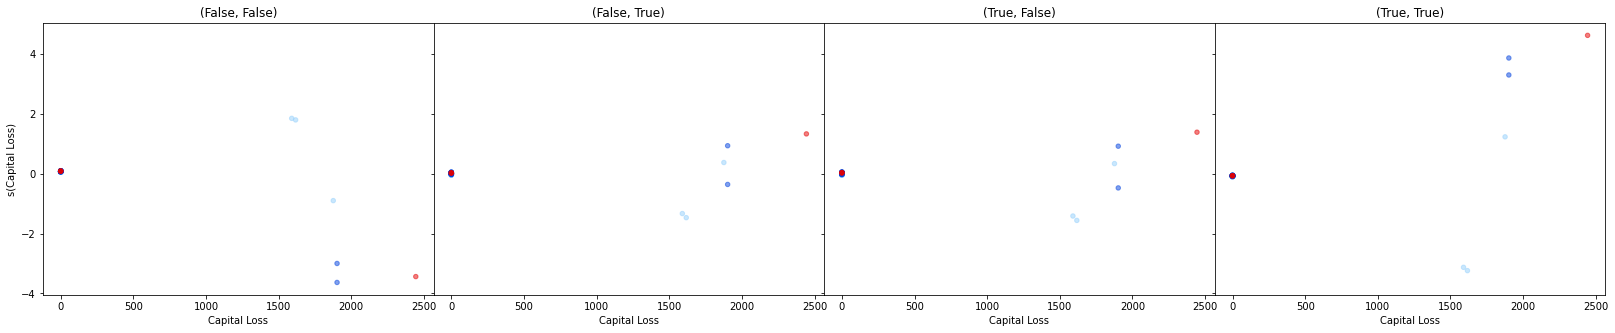

2.0 <= Marital Status <= 4.0
[]


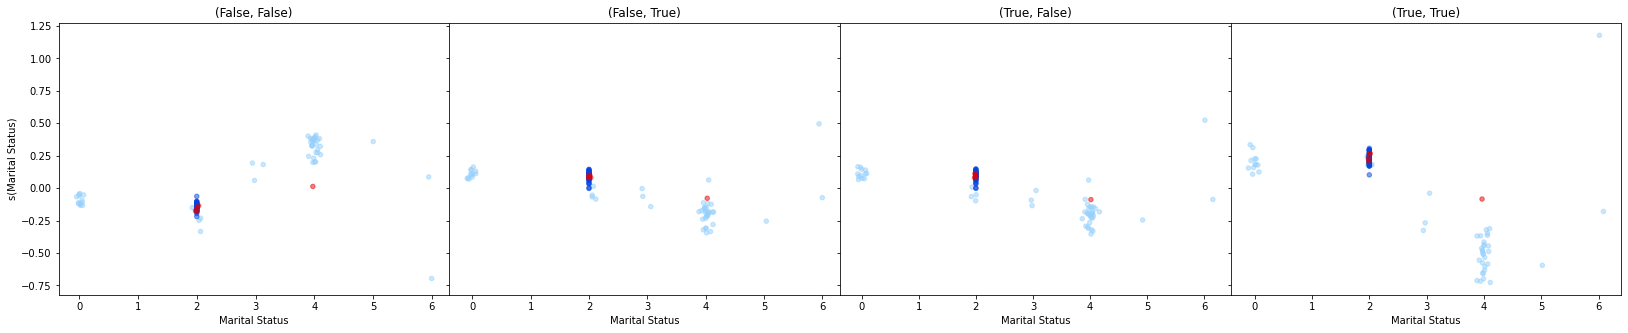

Sex
[]


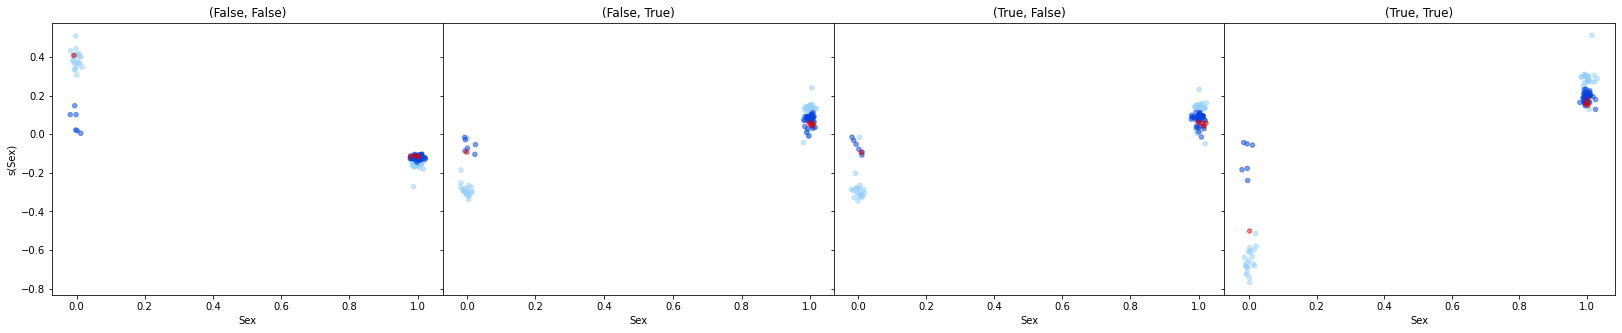

Workclass == 4.0
[]


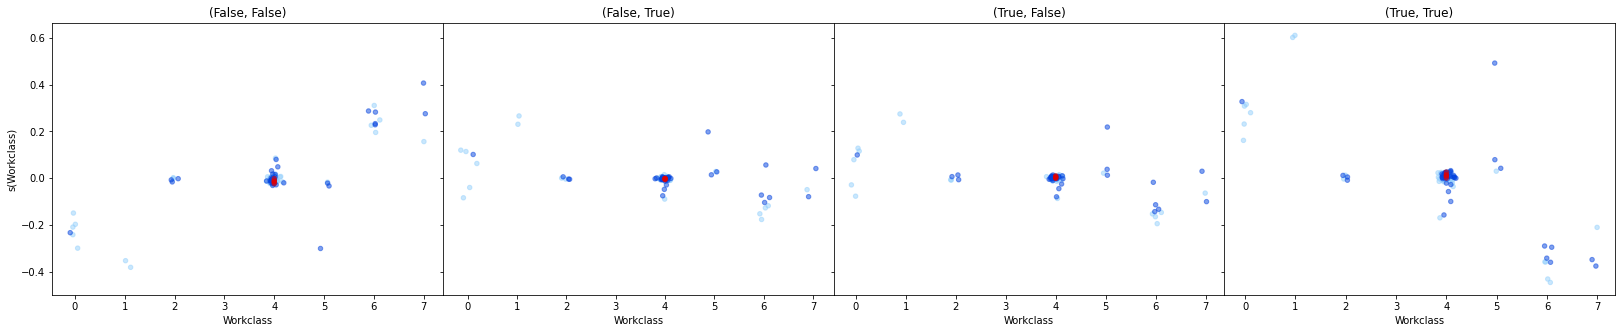

Race == 4.0
[]


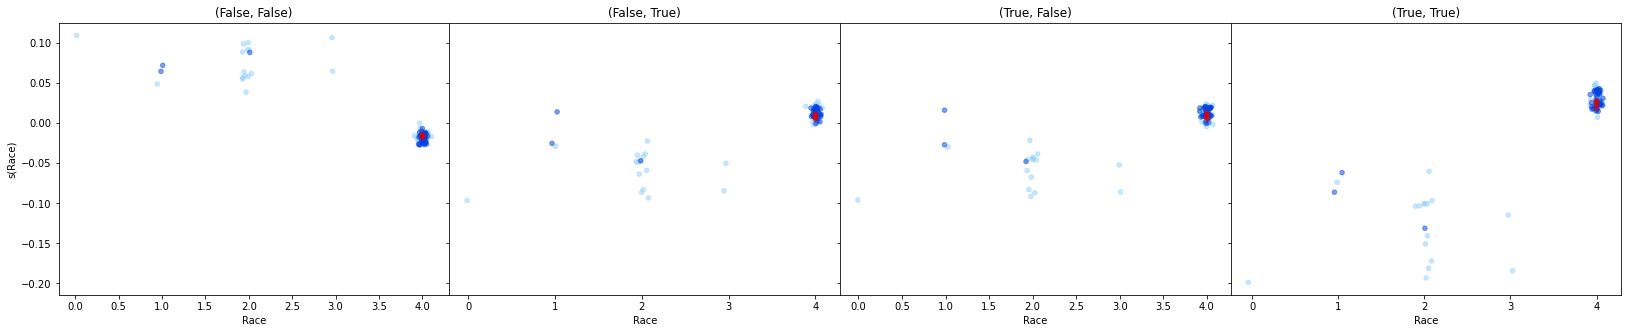

Country == 39.0
[]


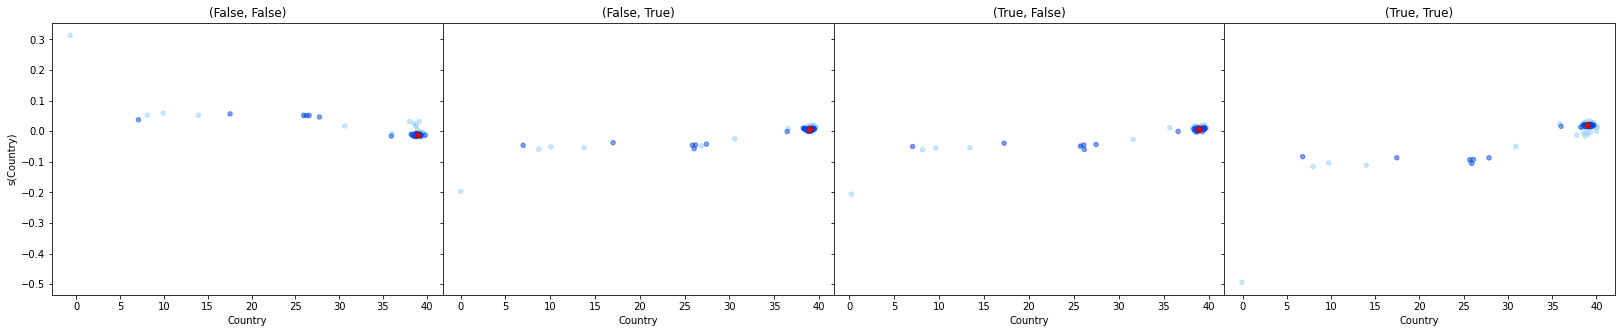

In [32]:
node.root.plot_feature_dependence(focus=node, print_stats=True);

### Node 1 (RLRRR)

In [36]:
path = [node]
node = node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLRRR,
 (True, False)    1
 dtype: int64,
 0)

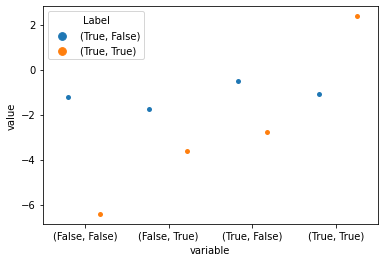

In [37]:
node.get_parent().plot_outcomes()

In [38]:
print(node.rule_from_counterfactuals()[0])

`Capital Loss` > 2384 and Relationship <= 2 and Age > 35 and 2 < Occupation <= 4 and `Capital Gain` <= 56 and Sex <= 0 and 34 < `Hours per week` <= 44 and 8 < `Education-Num` <= 12


Capital Loss == 2444.0
[Lower CF: Capital Loss == 2384.0 --> {'(False, False)': 1}]


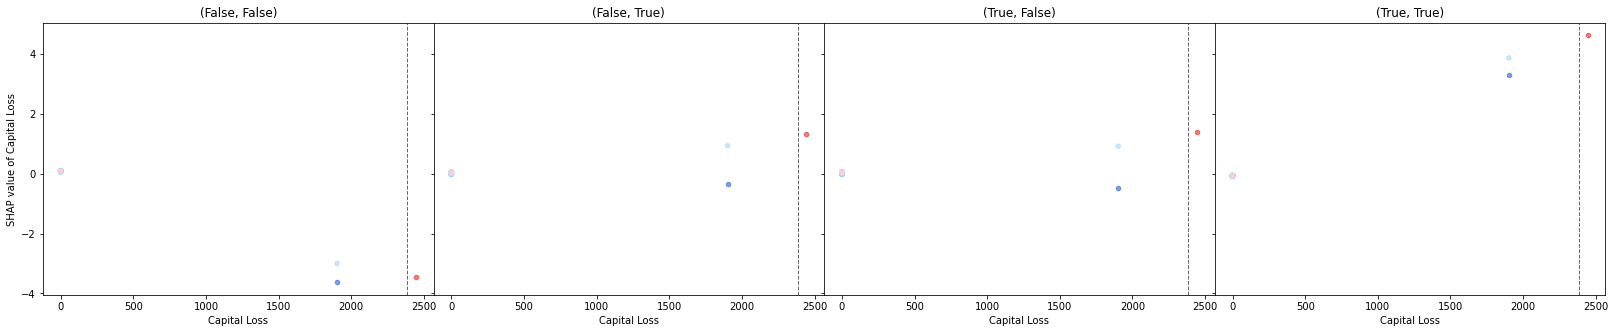

Relationship == 0.0
[Upper CF: Relationship == 3.0 --> {'(False, False)': 1}]


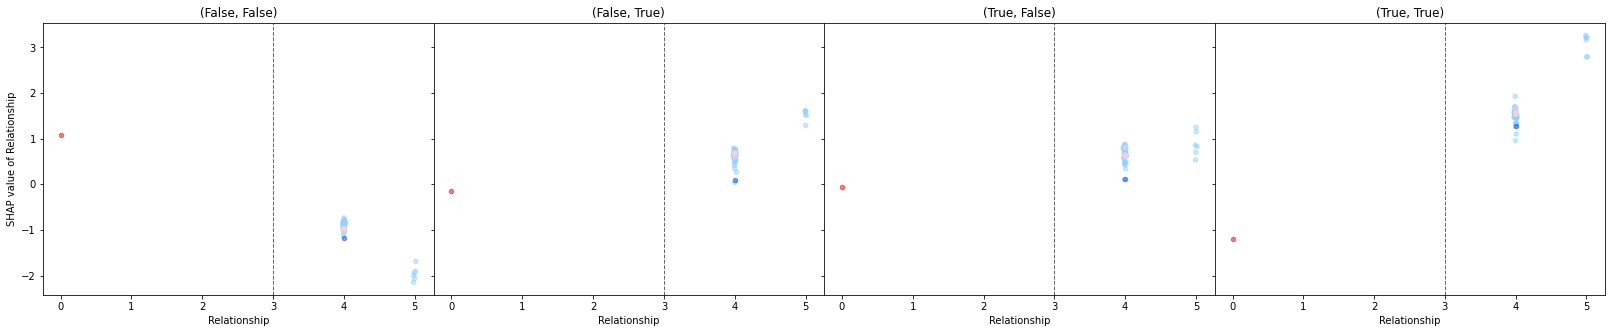

Education-Num == 10.0
[Lower CF: Education-Num == 8.0 --> {'(False, False)': 1},
 Upper CF: Education-Num == 13.0 --> {'(True, True)': 1}]


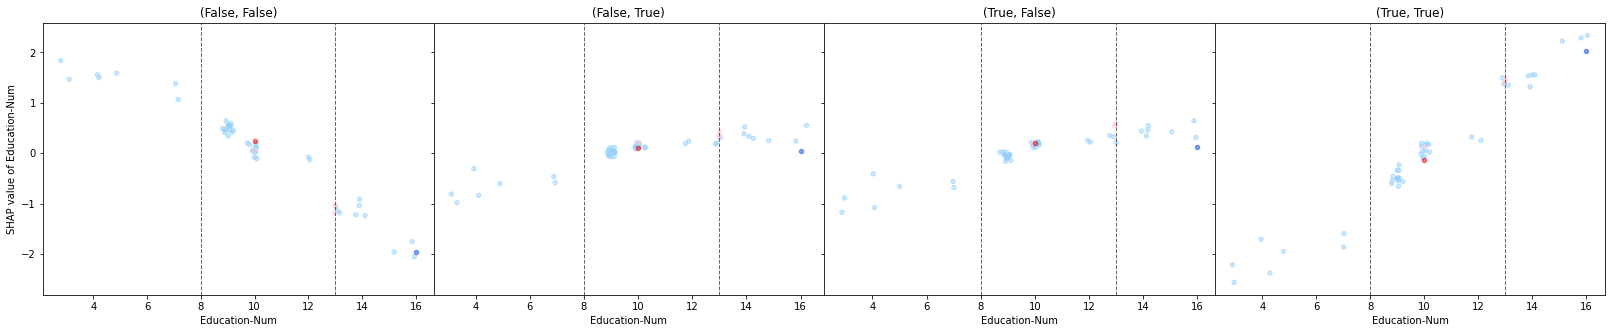

Age == 42.0
[Lower CF: Age == 35.0 --> {'(False, False)': 1}]


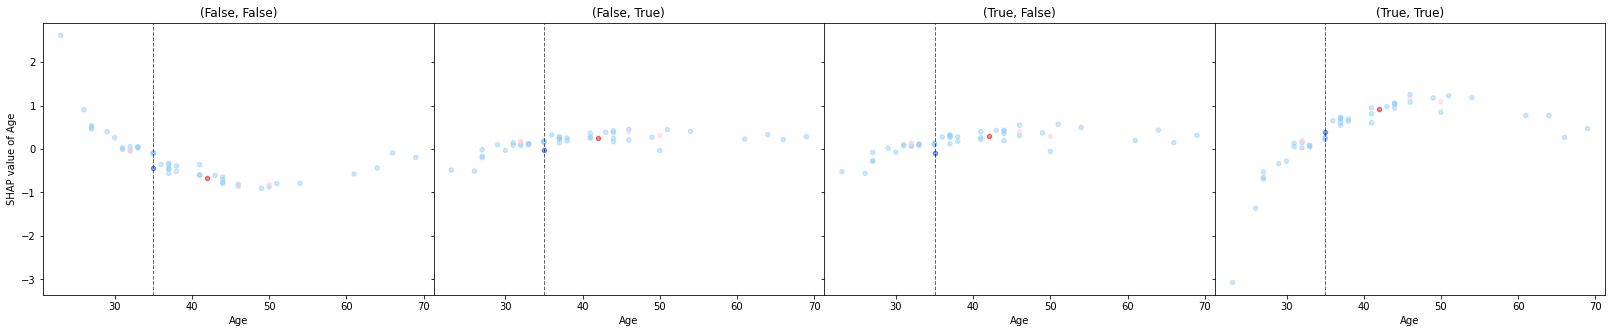

Occupation == 4.0
[Lower CF: Occupation == 2.0 --> {'(False, False)': 1},
 Upper CF: Occupation == 5.0 --> {'(False, False)': 1}]


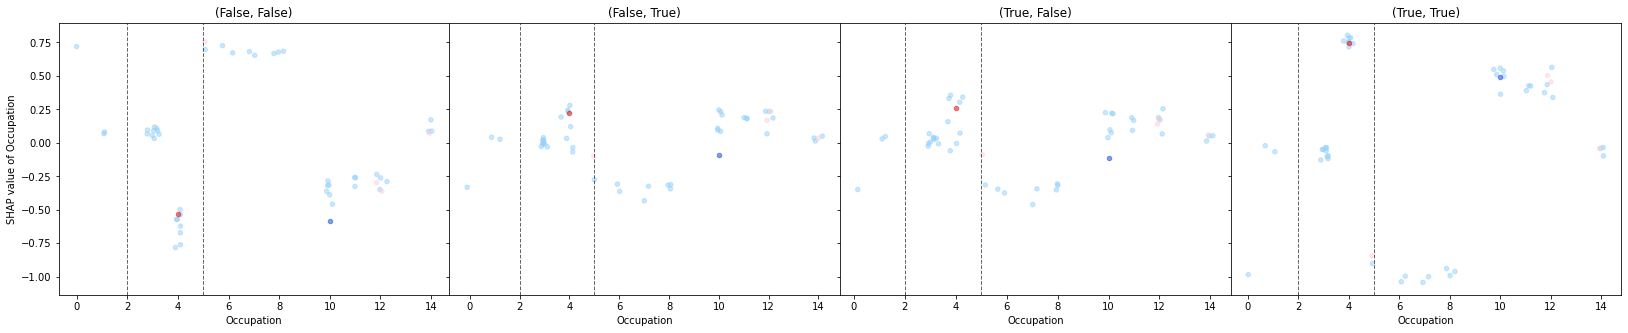

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 1}]


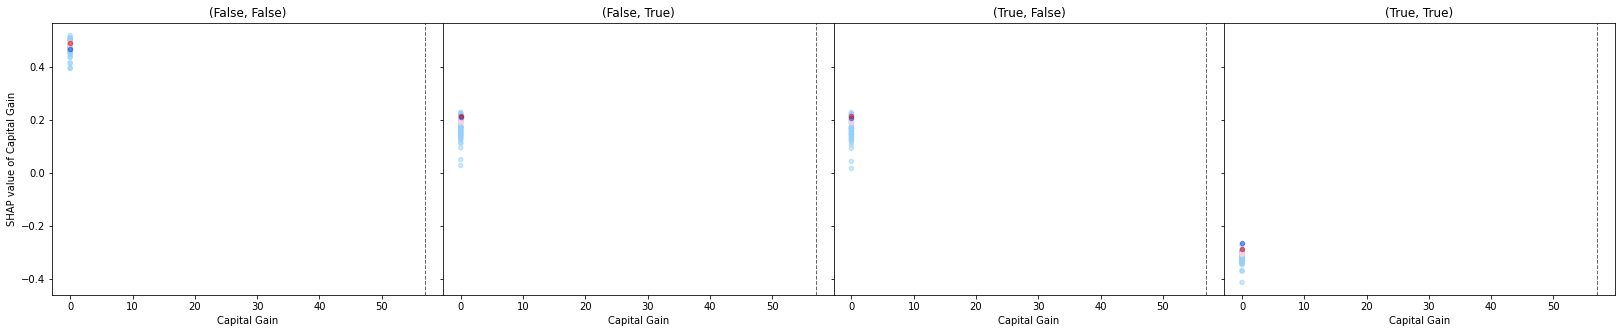

Hours per week == 40.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 1},
 Upper CF: Hours per week == 45.0 --> {'(True, True)': 1}]


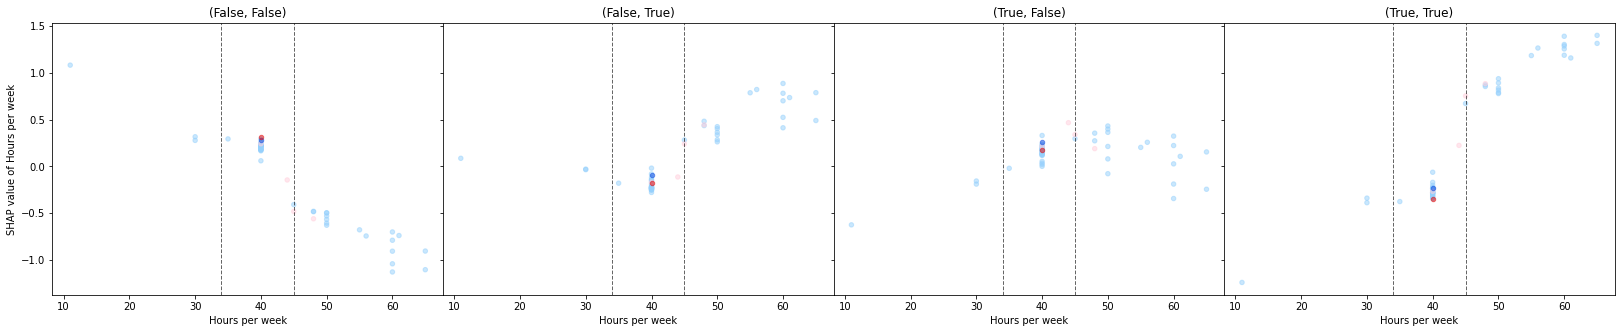

Sex == 0.0
[Upper CF: Sex == 1.0 --> {'(True, True)': 1}]


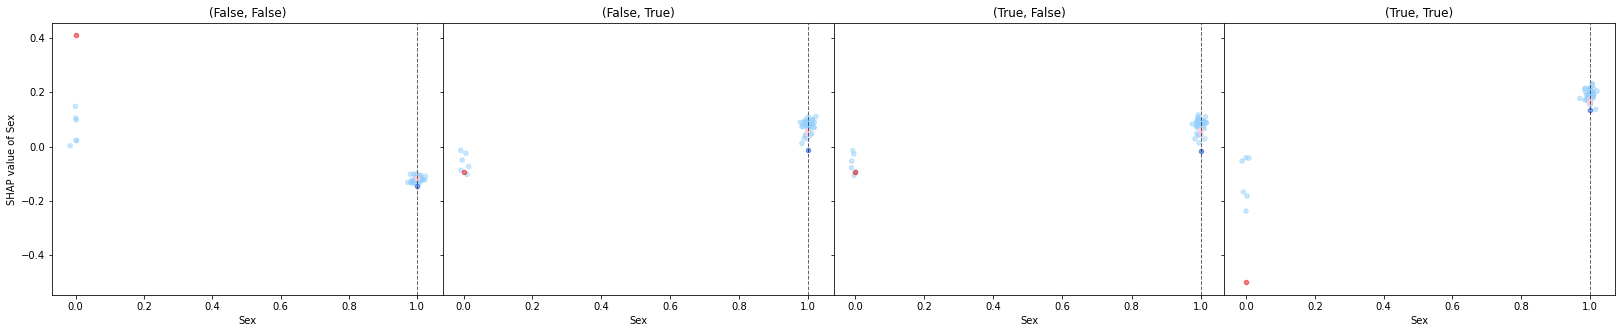

Marital Status == 4.0
[]


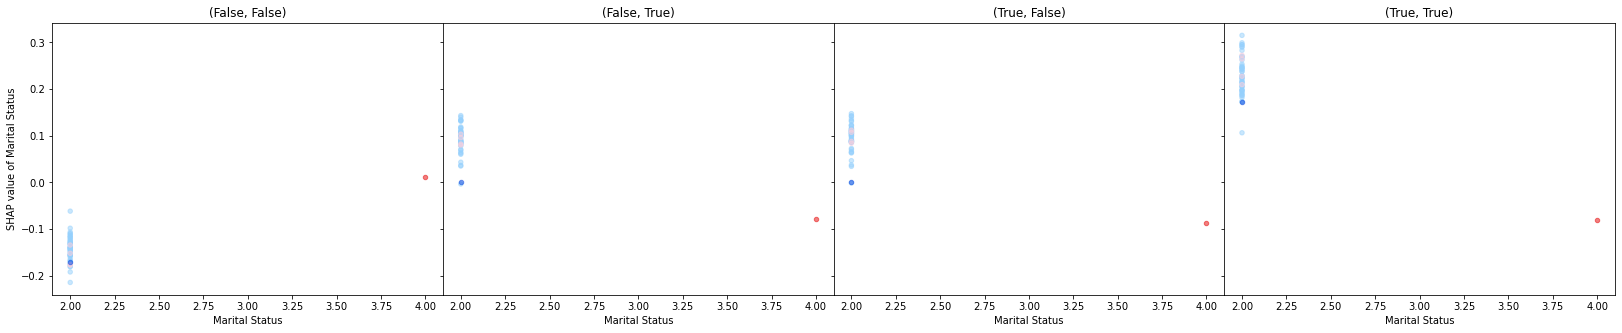

In [49]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:9], focus=node.parent, print_stats=True);

In [127]:
X = node.data[node.highlight].copy()
X['Relationship'] = 4
comparer.class_names[comparer.predict_mclass_diff(X)]

array(['(True, True)'], dtype='<U14')

In [128]:
X = node.data[node.highlight].copy()
X['Relationship'] = 5
comparer.class_names[comparer.predict_mclass_diff(X)]

array(['(True, True)'], dtype='<U14')

### Node 2 (RLL)

In [39]:
node = path[-1].left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLL,
 (False, False)    32
 (True, True)      11
 (True, False)      4
 dtype: int64,
 51.498931921916956)

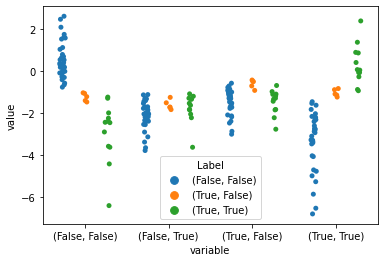

In [40]:
node.get_parent().plot_outcomes()

In [41]:
print(node.rule_from_counterfactuals()[0])

Relationship > 3 and `Education-Num` > 9 and 34 < `Hours per week` <= 54 and Age > 26 and `Capital Gain` <= 56 and `Capital Loss` <= 1447


Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 4}]


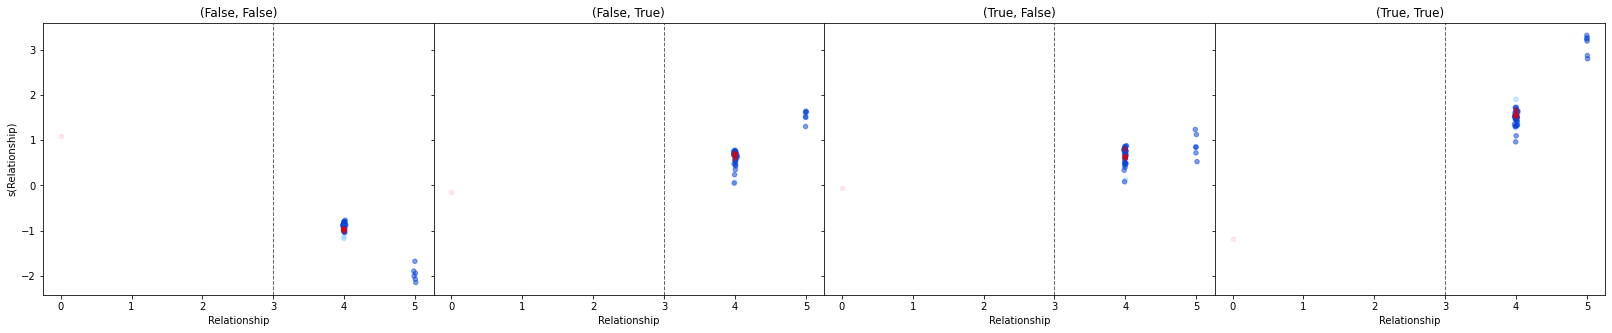

10.0 <= Education-Num <= 13.0
[Lower CF: Education-Num == 9.0 --> {'(False, False)': 4}]


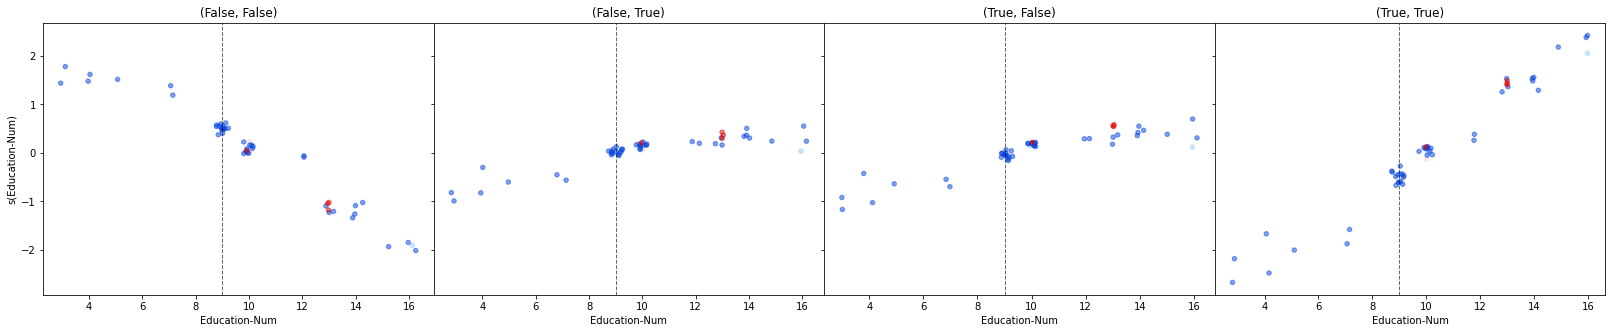

40.0 <= Hours per week <= 48.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 4},
 Upper CF: Hours per week == 55.0 --> {'(True, True)': 4}]


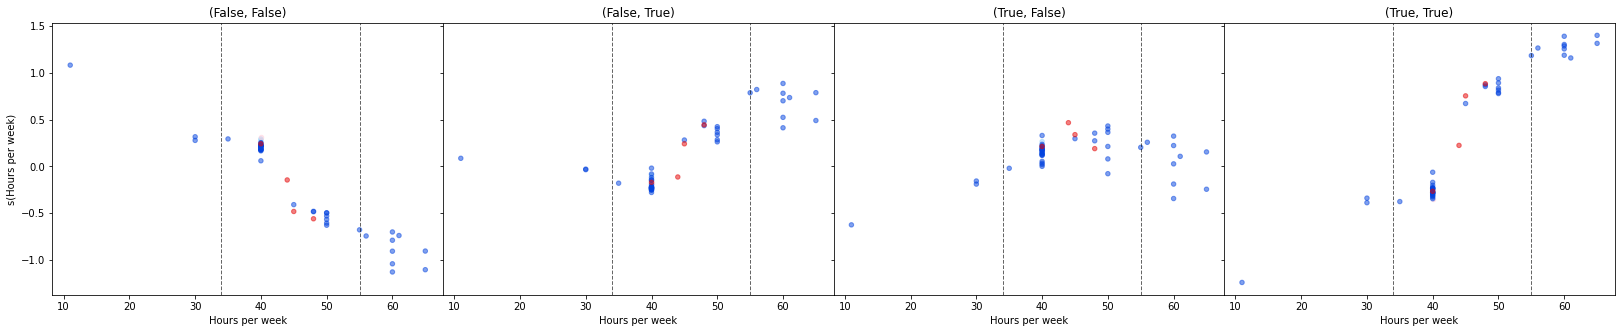

32.0 <= Age <= 50.0
[Lower CF: Age == 26.0 --> {'(False, False)': 4}]


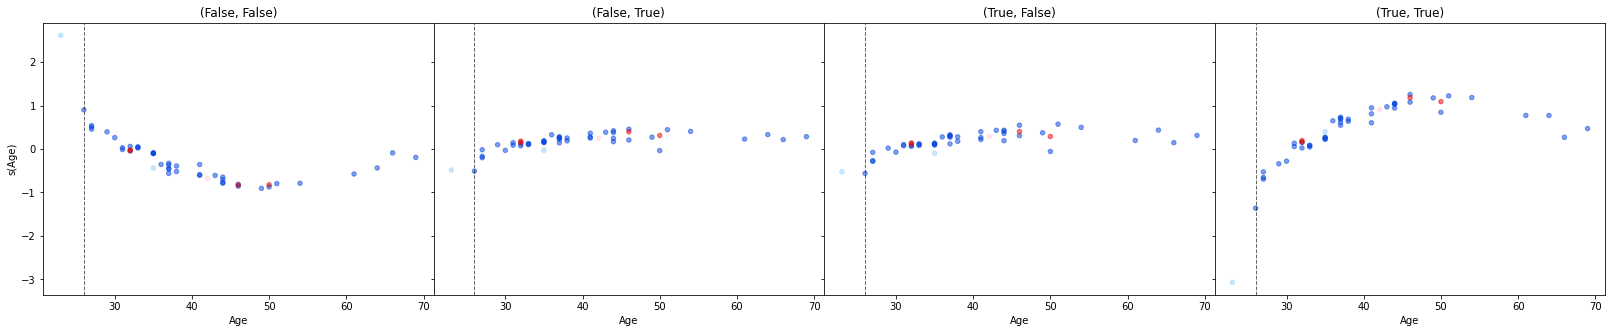

5.0 <= Occupation
[]


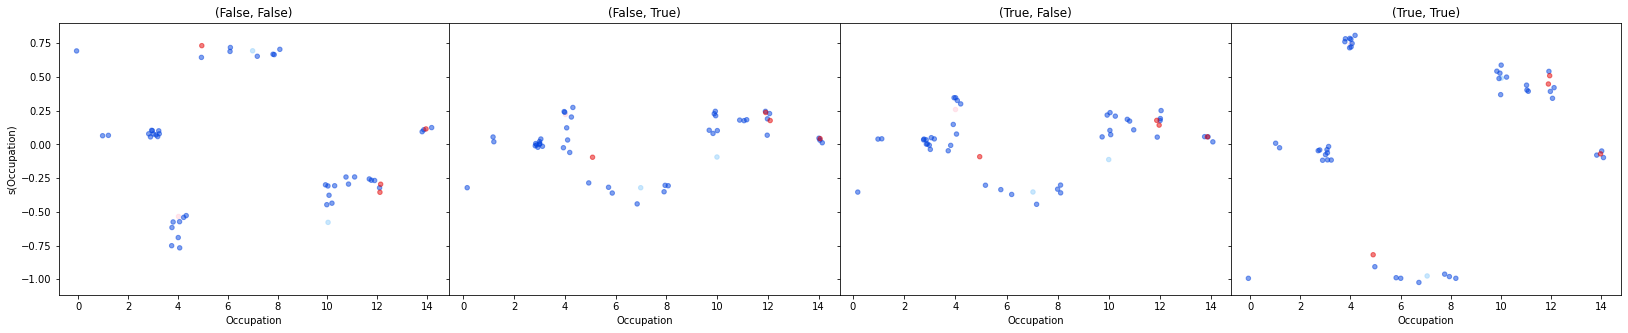

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 4}]


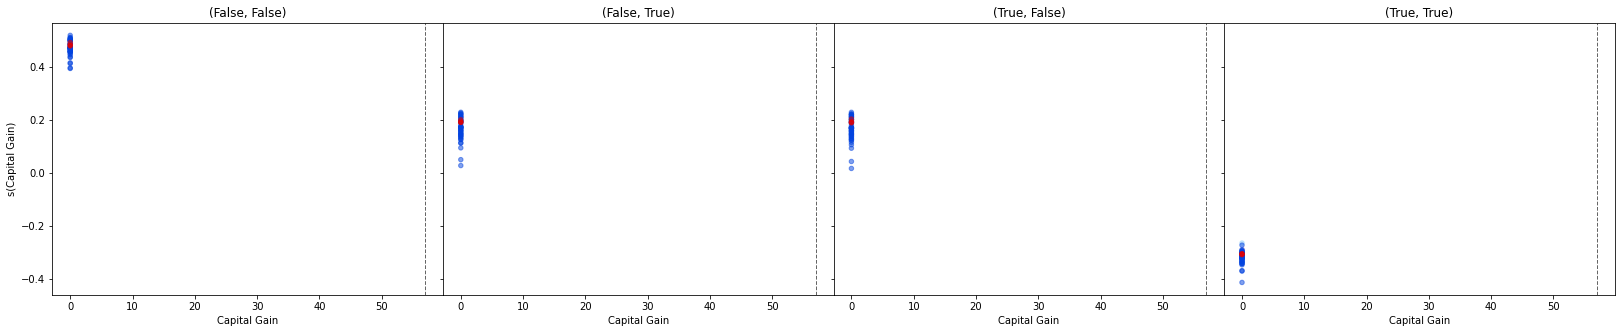

Marital Status == 2.0
[]


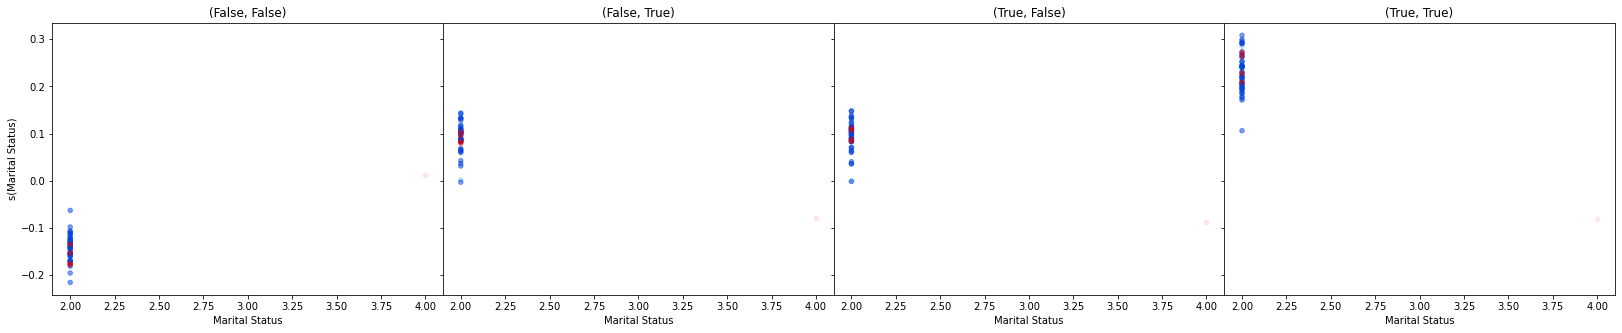

Sex == 1.0
[]


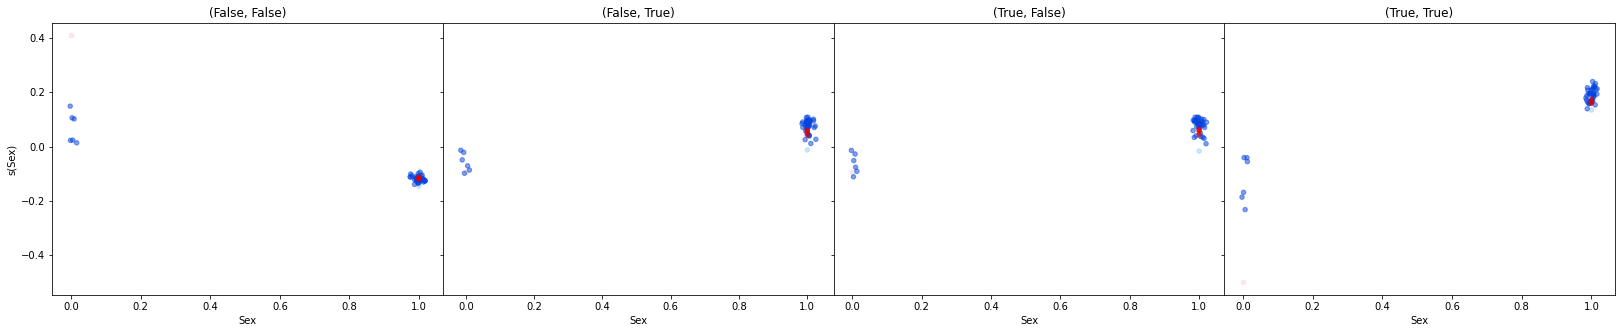

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 4}]


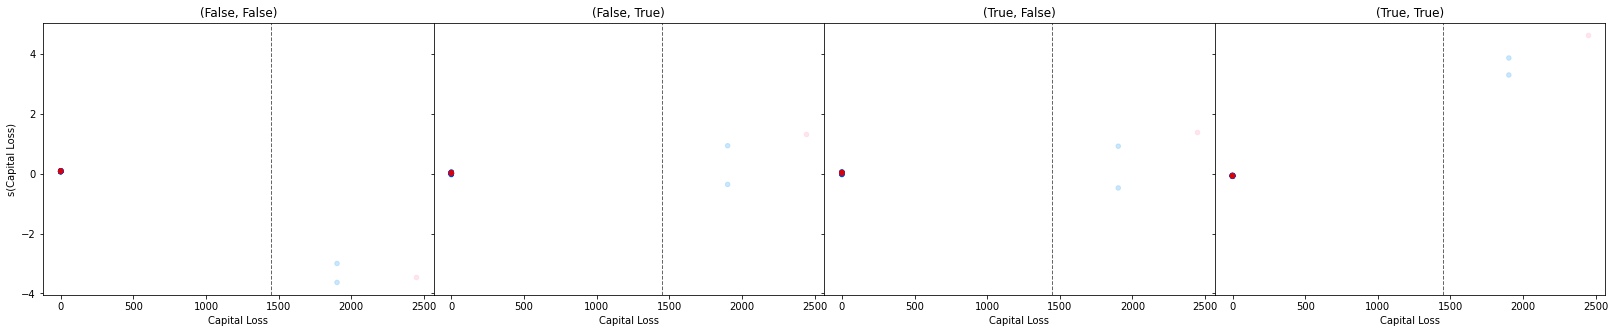

In [42]:
path[-1].plot_feature_dependence(*node.features_ordered[:-3], focus=node, print_stats=True);

### Node 2.1 (RLLRRRRRL)

In [43]:
path.append(node)
node = node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLRRRRRL,
 (True, False)    1
 dtype: int64,
 0)

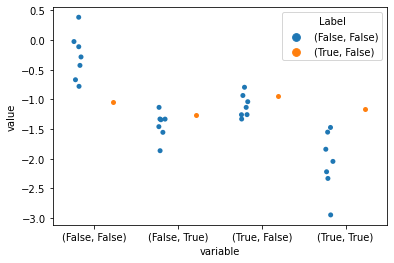

In [44]:
node.get_parent().plot_outcomes()

In [45]:
print(node.rule_from_counterfactuals()[0])

Relationship > 3 and 44 < Age <= 59 and 44 < `Hours per week` <= 54 and `Capital Gain` <= 56 and 9 < `Education-Num` <= 11 and `Marital Status` <= 2 and Sex > 0 and Occupation > 13 and `Capital Loss` <= 1447 and 1 < Workclass <= 5 and Country > 0


In [129]:
node = node.root.get('RLLRRRRRL')

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 1}]


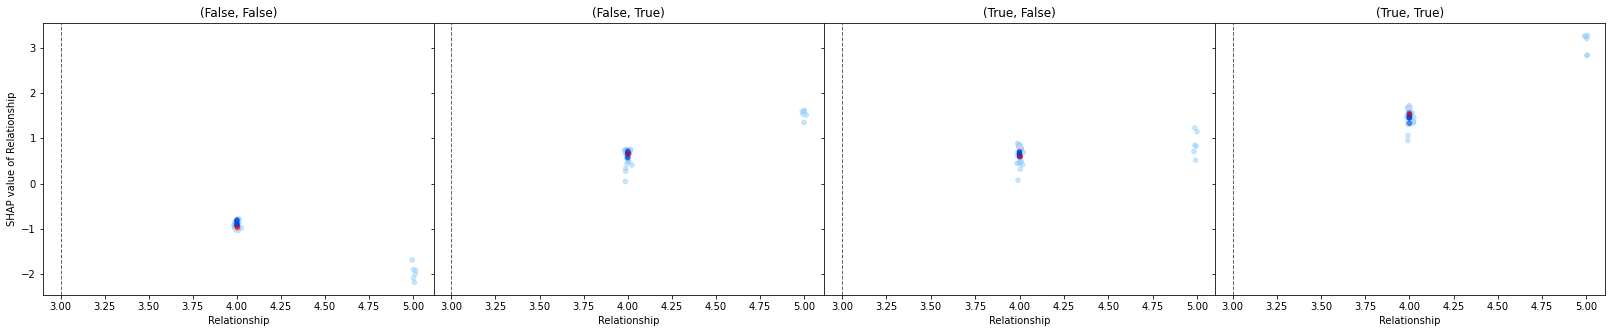

Hours per week == 48.0
[Lower CF: Hours per week == 44.0 --> {'(False, False)': 1},
 Upper CF: Hours per week == 55.0 --> {'(True, True)': 1}]


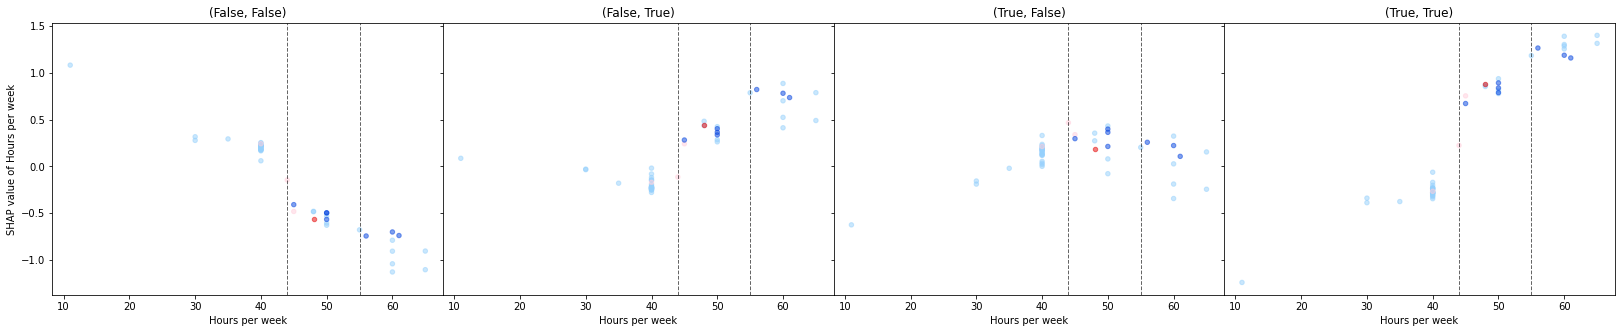

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 1}]


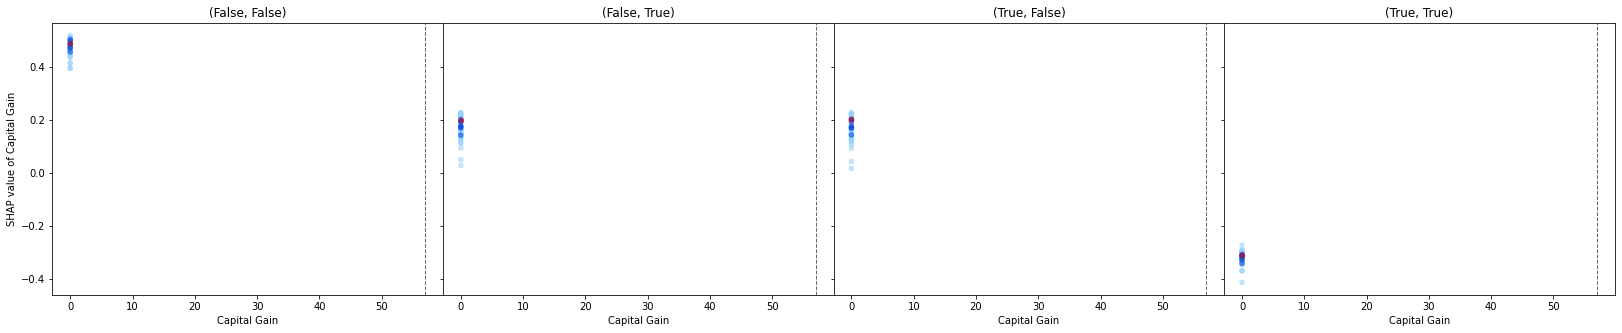

Occupation == 14.0
[Lower CF: Occupation == 13.0 --> {'(True, True)': 1}]


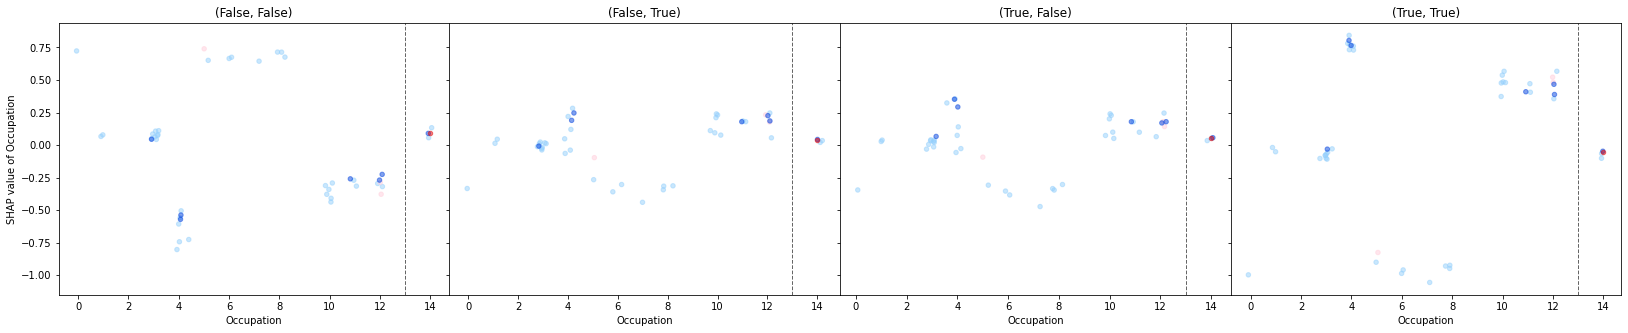

Age == 46.0
[Lower CF: Age == 44.0 --> {'(False, False)': 1},
 Upper CF: Age == 60.0 --> {'(False, False)': 1}]


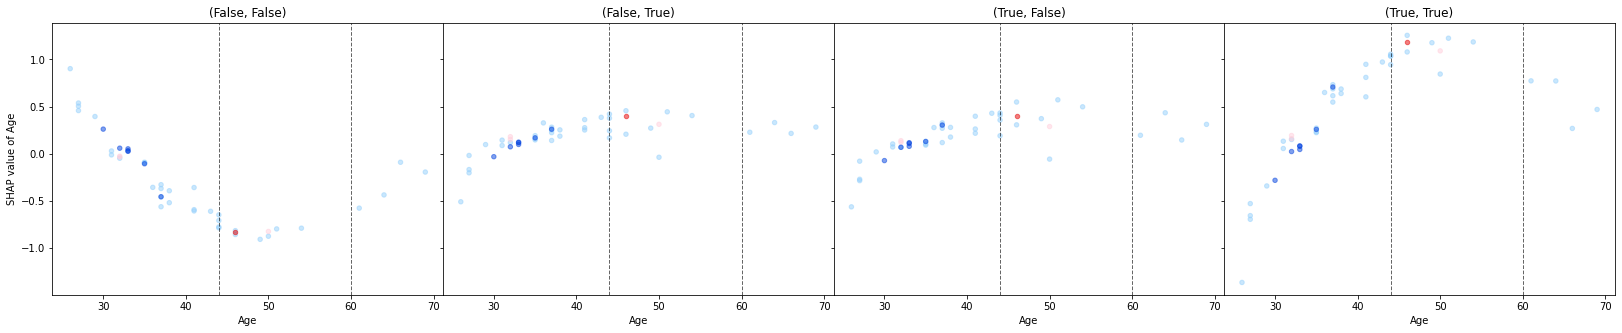

Education-Num == 10.0
[Lower CF: Education-Num == 9.0 --> {'(False, False)': 1},
 Upper CF: Education-Num == 12.0 --> {'(False, False)': 1}]


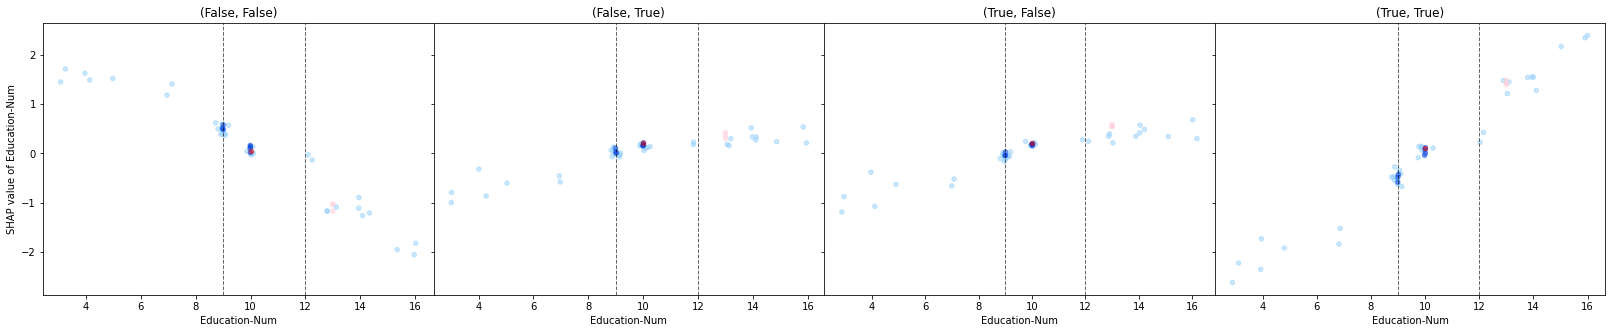

Marital Status == 2.0
[Upper CF: Marital Status == 3.0 --> {'(False, False)': 1}]


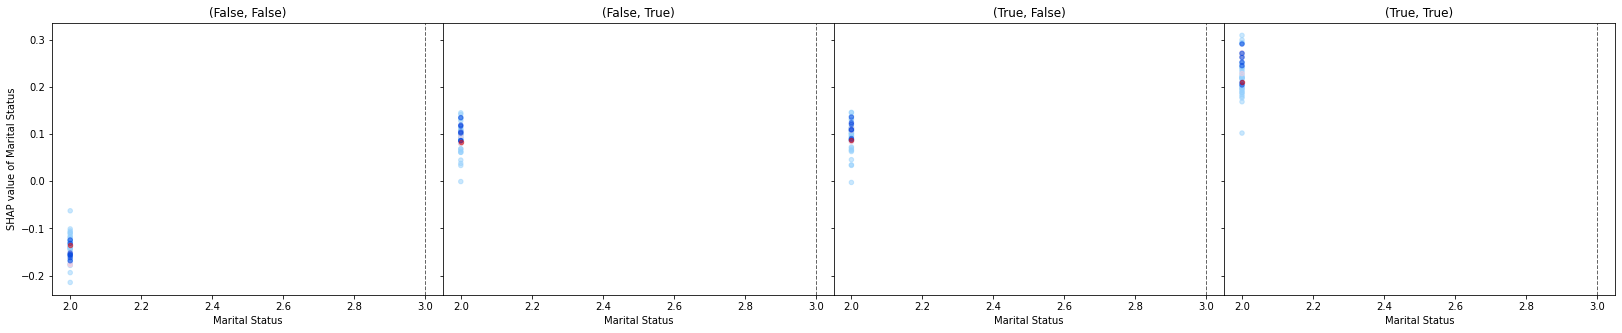

Sex == 1.0
[Lower CF: Sex == 0.0 --> {'(False, False)': 1}]


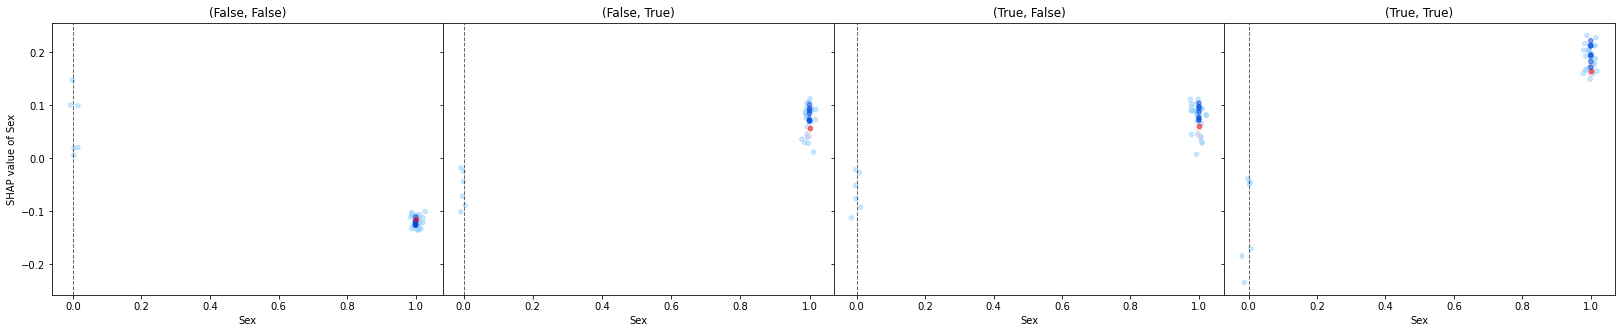

Capital Loss == 0.0
[Upper CF: Capital Loss == 1448.0 --> {'(True, True)': 1}]


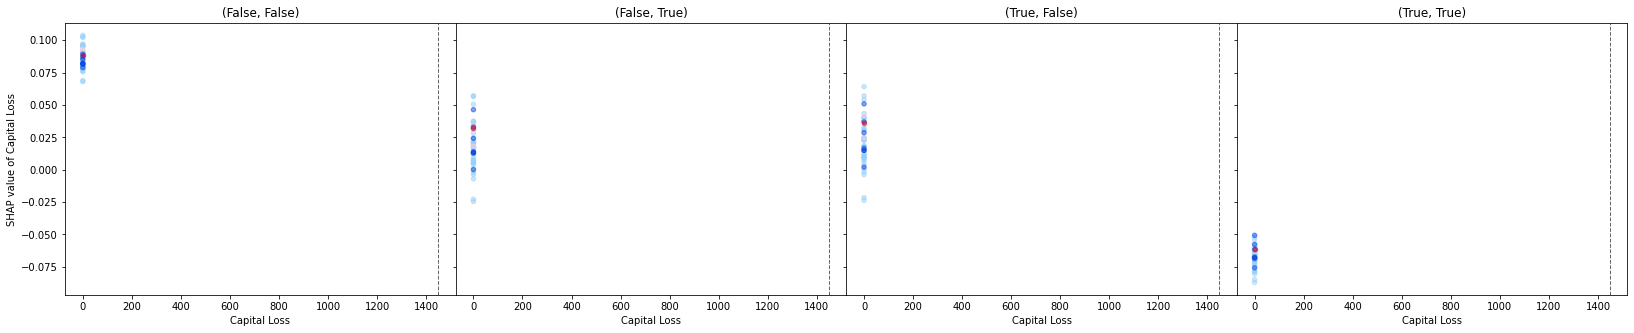

Workclass == 4.0
[Lower CF: Workclass == 1.0 --> {'(True, True)': 1},
 Upper CF: Workclass == 6.0 --> {'(False, False)': 1}]


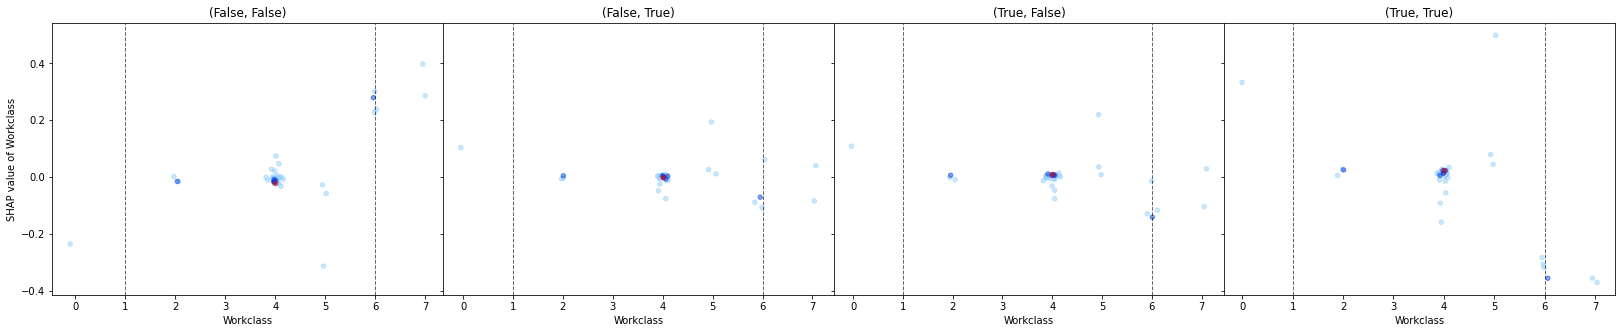

In [55]:
path[-1].plot_feature_dependence(*node.parent.features_ordered[:-2], focus=node.parent, print_stats=True);

In [131]:
X = node.data[node.highlight].copy()
X['Education-Num'] = 13
comparer.class_names[comparer.predict_mclass_diff(X)]

array(['(True, True)'], dtype='<U14')

### Node 2.2 (RLLL)

In [46]:
node = path[-1].left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RLLL,
 (True, True)      9
 (True, False)     3
 (False, False)    1
 dtype: int64,
 20.43439220003462)

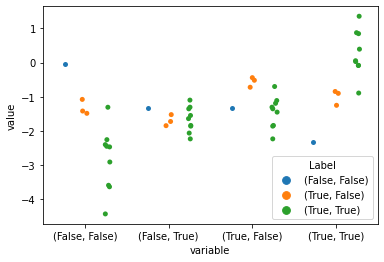

In [47]:
node.plot_outcomes()

In [48]:
print(node.rule_from_counterfactuals()[0])

`Education-Num` > 12 and 3 < Relationship <= 4 and 34 < `Hours per week` <= 45 and Age > 26 and `Capital Gain` <= 56 and `Capital Loss` <= 1447


Education-Num == 13.0
[Lower CF: Education-Num == 12.0 --> {'(False, False)': 3}]


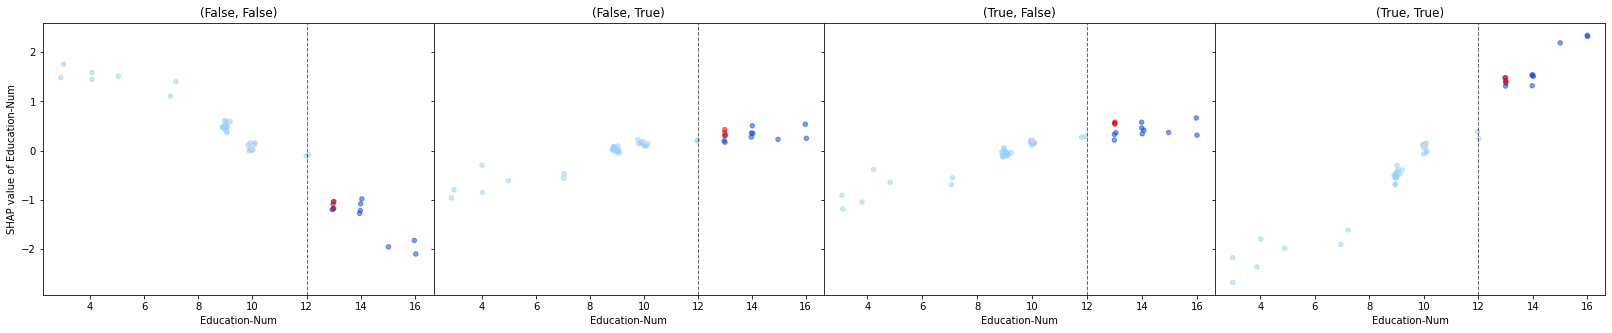

Relationship == 4.0
[Lower CF: Relationship == 3.0 --> {'(False, False)': 3},
 Upper CF: Relationship == 5.0 --> {'(True, True)': 3}]


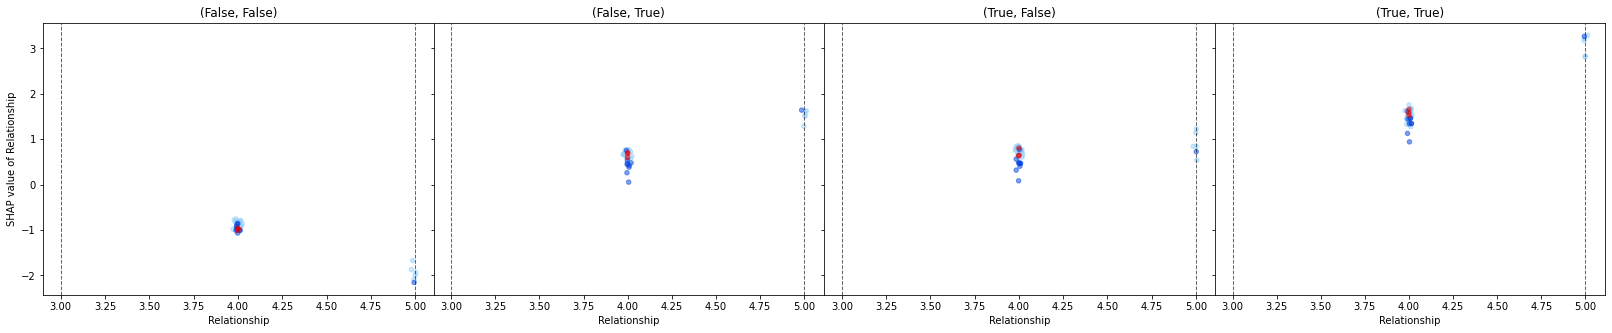

40.0 <= Hours per week <= 45.0
[Lower CF: Hours per week == 34.0 --> {'(False, False)': 3},
 Upper CF: Hours per week == 46.0 --> {'(True, True)': 3}]


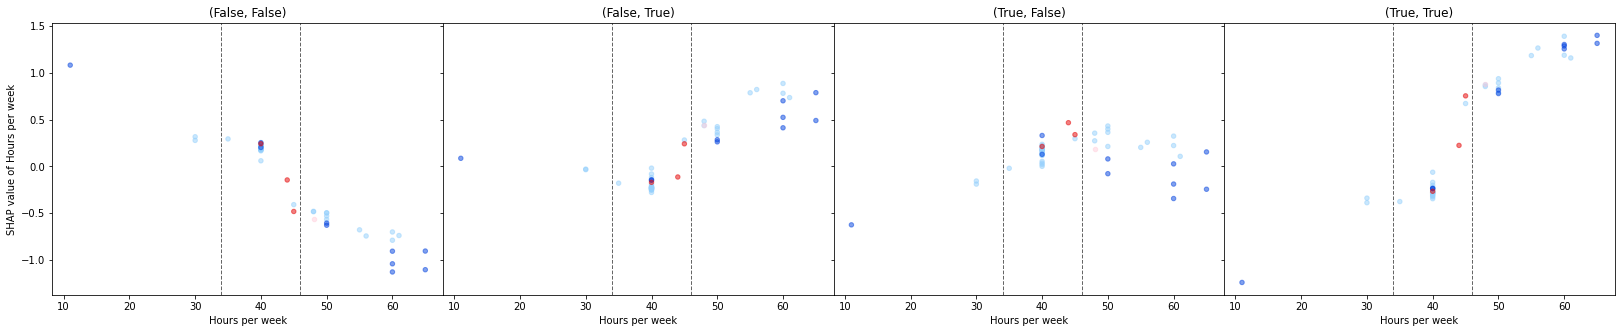

32.0 <= Age <= 50.0
[Lower CF: Age == 26.0 --> {'(False, False)': 3}]


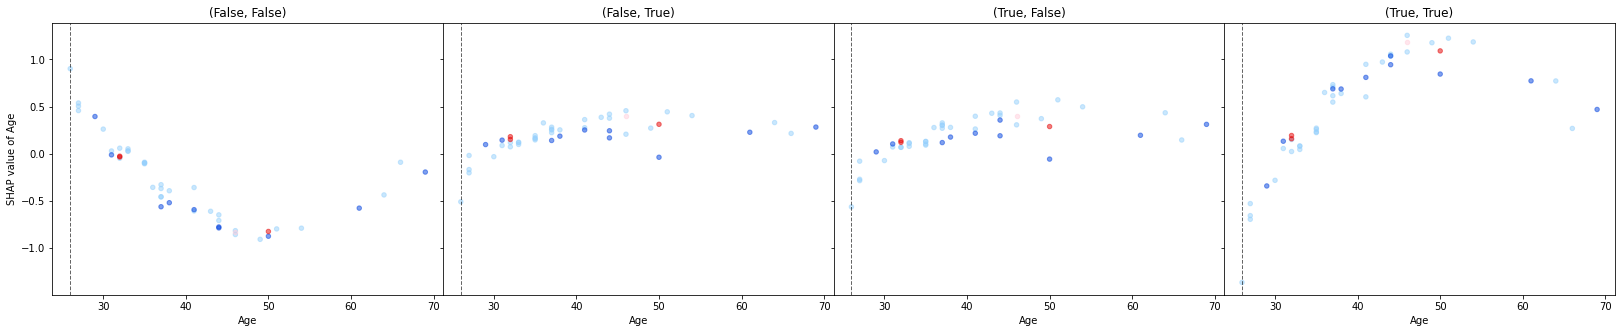

5.0 <= Occupation <= 12.0
[]


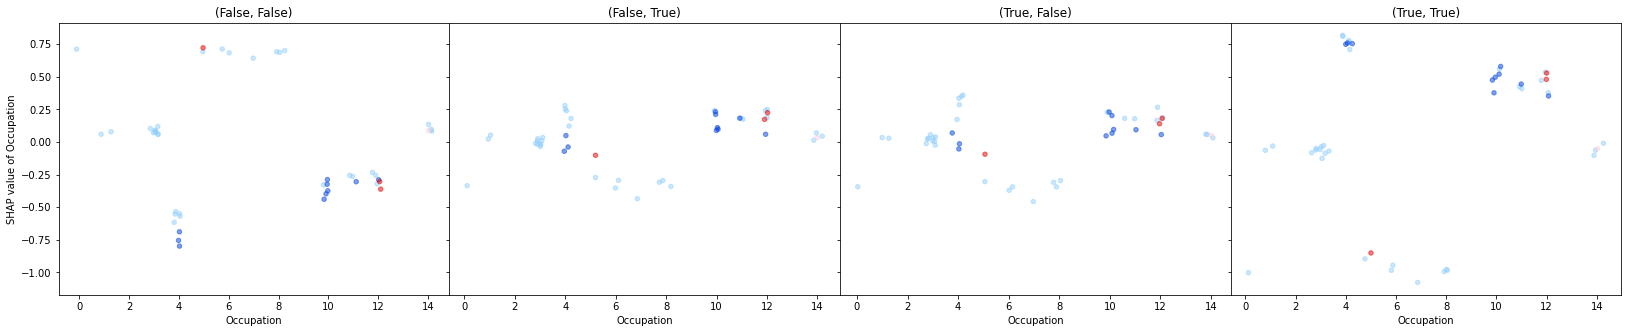

Capital Gain == 0.0
[Upper CF: Capital Gain == 57.0 --> {'(False, False)': 3}]


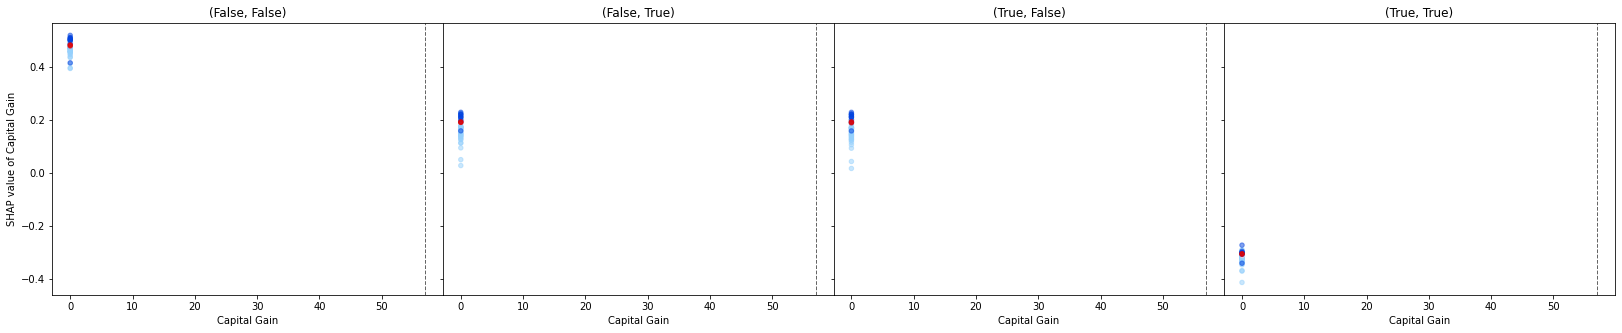

In [58]:
path[-1].plot_feature_dependence(*node.features_ordered[:-6], focus=node, print_stats=True);

# Evaluation

In [6]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

In [7]:
with open('data/test.pickle', 'rb') as f:
    X_test, X_test_display, y_test = pickle.load(f)

In [16]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/test.log_odds.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Permutation explainer: 4786it [07:40, 10.23it/s]                          


CPU times: user 23min 45s, sys: 1min 29s, total: 25min 14s
Wall time: 7min 40s


In [8]:
with open('explanations/test.log_odds.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [9]:
explanations_per_class = {}
for class_name in comparer.class_names:
    explanations_per_class[class_name] = load(class_name)

In [139]:
metrics = eval_clusterings(explanations_per_class, X_test, comparer.predict_mclass_diff(X_test), shap_values_test)
metrics

,Precision,Recall,F1 Score,Support,Label,Nodes,Constraints,Distance
0,0.000000,0.000000,0.000000,3854.0,"(False, False)",1,0,281.168545
1,0.660891,0.346393,0.454545,3854.0,"(False, False)",2,1,82.209763
2,0.690427,0.344318,0.459488,3854.0,"(False, False)",3,6,51.630170
3,0.690427,0.344318,0.459488,3854.0,"(False, False)",4,6,48.384964
4,0.761793,0.507006,0.608818,3854.0,"(False, False)",5,7,37.999186
...,...,...,...,...,...,...,...,...
64,0.606846,0.854015,0.709521,685.0,"(True, True)",9,42,1.943970
65,0.647778,0.851095,0.735647,685.0,"(True, True)",10,48,1.194865
66,0.667820,0.845255,0.746134,685.0,"(True, True)",11,64,0.800321
67,0.851138,0.709489,0.773885,685.0,"(True, True)",12,71,0.387159


In [140]:
grouped_metrics, constraints = group_metrics(metrics, by='Distance', direction='down')
with open('data/fidelity-shap.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

In [10]:
with open('data/fidelity-shap.pickle', 'rb') as f:
    grouped_metrics, constraints = pickle.load(f)

In [142]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes  \
Level                                                                    
0     0  (False, False)   0.000000  0.000000  0.000000   3854.0    1.0   
      1   (True, False)   0.100177  0.949580  0.181235    238.0    1.0   
      2    (True, True)   0.000000  0.000000  0.000000    685.0    1.0   
1     0  (False, False)   0.000000  0.000000  0.000000   3854.0    1.0   
      1   (True, False)   0.100177  0.949580  0.181235    238.0    1.0   
...                 ...        ...       ...       ...      ...    ...   
58    1   (True, False)   0.660194  0.285714  0.398827    238.0    4.0   
      2    (True, True)   0.851138  0.709489  0.773885    685.0   12.0   
59    0  (False, False)   0.974308  0.895433  0.933207   3854.0   78.0   
      1   (True, False)   0.720430  0.281513  0.404834    238.0    5.0   
      2    (True, True)   0.840136  0.721168  0.776119    685.0   17.0   

         Constraints    Distance  
Level                             
0     0          0.0  281.168545  
      1          5.0  281.168545  
      2          0.0  281.168545  
1     0          0.0  281.168545  
      1          5.0  281.168545  
...              ...         ...  
58    1         48.0   14.144280  
      2         71.0    0.387159  
59    0        186.0    0.000000  
      1         62.0    0.000000  
      2         91.0    0.000000  

[180 rows x 8 columns]

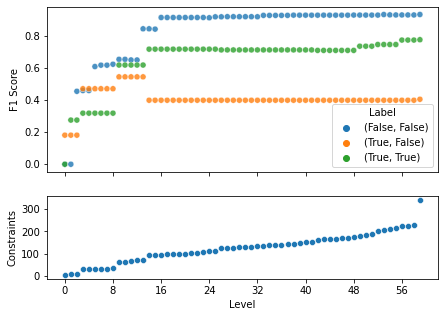

In [143]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [24]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes  \
Level                                                                    
0     0  (False, False)   0.000000  0.000000  0.000000   3633.0    1.0   
      1   (True, False)   0.000000  0.000000  0.000000      0.0    1.0   
      2    (True, True)   0.000000  0.000000  0.000000      0.0    1.0   
1     0  (False, False)   0.000000  0.000000  0.000000   3633.0    1.0   
      1   (True, False)   0.000000  0.000000  0.000000      0.0    1.0   
...                 ...        ...       ...       ...      ...    ...   
58    1   (True, False)   0.000000  0.000000  0.000000      0.0    4.0   
      2    (True, True)   0.000000  0.000000  0.000000      0.0   12.0   
59    0  (False, False)   0.873518  0.851638  0.862439   3633.0   78.0   
      1   (True, False)   0.000000  0.000000  0.000000      0.0    5.0   
      2    (True, True)   0.000000  0.000000  0.000000      0.0   17.0   

         Constraints    Distance  
Level                             
0     0          0.0  281.168545  
      1          5.0  281.168545  
      2          0.0  281.168545  
1     0          0.0  281.168545  
      1          5.0  281.168545  
...              ...         ...  
58    1         48.0   14.144280  
      2         71.0    0.387159  
59    0        186.0    0.000000  
      1         62.0    0.000000  
      2         91.0    0.000000  

[180 rows x 8 columns]

In [25]:
constraints

Level
0       5.0
1       8.0
2       9.0
3      31.0
4      31.0
5      32.0
6      33.0
7      34.0
8      35.0
9      63.0
10     65.0
11     68.0
12     70.0
13     71.0
14     93.0
15     95.0
16     96.0
17     97.0
18     99.0
19    100.0
20    101.0
21    102.0
22    105.0
23    108.0
24    112.0
25    113.0
26    124.0
27    125.0
28    127.0
29    129.0
30    130.0
31    132.0
32    135.0
33    136.0
34    139.0
35    140.0
36    141.0
37    144.0
38    145.0
39    148.0
40    151.0
41    154.0
42    160.0
43    164.0
44    167.0
45    168.0
46    169.0
47    170.0
48    175.0
49    181.0
50    184.0
51    187.0
52    203.0
53    207.0
54    212.0
55    215.0
56    222.0
57    226.0
58    230.0
59    339.0
Name: Constraints, dtype: float64

In [144]:
for label in comparer.class_names:
    print(label)
    display(metrics[metrics['Label'] == label].describe())

(False, False)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000
mean,0.895504,0.795384,0.836091,3854.0,26.529412,50.901961,15.895853
std,0.147655,0.212297,0.184756,0.0,16.195497,36.335798,40.953455
min,0.000000,0.000000,0.000000,3854.0,1.000000,0.000000,0.000000
25%,0.929886,0.831733,0.878421,3854.0,13.500000,23.500000,1.887546
50%,0.939854,0.899844,0.919406,3854.0,26.000000,46.000000,4.409439
75%,0.947156,0.911520,0.929015,3854.0,38.500000,75.500000,12.833094
max,0.974308,0.913337,0.933207,3854.0,78.000000,186.000000,281.168545


(False, True)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(True, False)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000
mean,0.473234,0.586555,0.400029,238.0,3.000000,33.400000,73.715257
std,0.258515,0.320798,0.135824,0.0,1.581139,22.777182,117.494457
min,0.100177,0.281513,0.181235,238.0,1.000000,5.000000,0.000000
25%,0.319759,0.285714,0.398827,238.0,2.000000,18.000000,14.144280
50%,0.565611,0.525210,0.404834,238.0,3.000000,34.000000,21.633290
75%,0.660194,0.890756,0.470588,238.0,4.000000,48.000000,51.630170
max,0.720430,0.949580,0.544662,238.0,5.000000,62.000000,281.168545


(True, True)


,Precision,Recall,F1 Score,Support,Nodes,Constraints,Distance
count,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,13.000000
mean,0.507147,0.781808,0.570636,685.0,7.307692,33.461538,42.398620
std,0.277824,0.252085,0.252715,0.0,4.516352,28.585006,80.761769
min,0.000000,0.000000,0.000000,685.0,1.000000,0.000000,0.000000
25%,0.190205,0.779562,0.318323,685.0,4.000000,8.000000,1.194865
50%,0.621064,0.837956,0.712329,685.0,7.000000,25.000000,9.034139
75%,0.664179,0.854015,0.735647,685.0,10.000000,48.000000,28.210025
max,0.851138,1.000000,0.776119,685.0,17.000000,91.000000,281.168545


# Additional plots

In [11]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [12]:
feature_order, _ = calc_feature_order(indiv_shap_values[:, :, 'B.True'] - indiv_shap_values[:, :, 'A.True'])
node = make_clustering(comparer, indiv_shap_values)

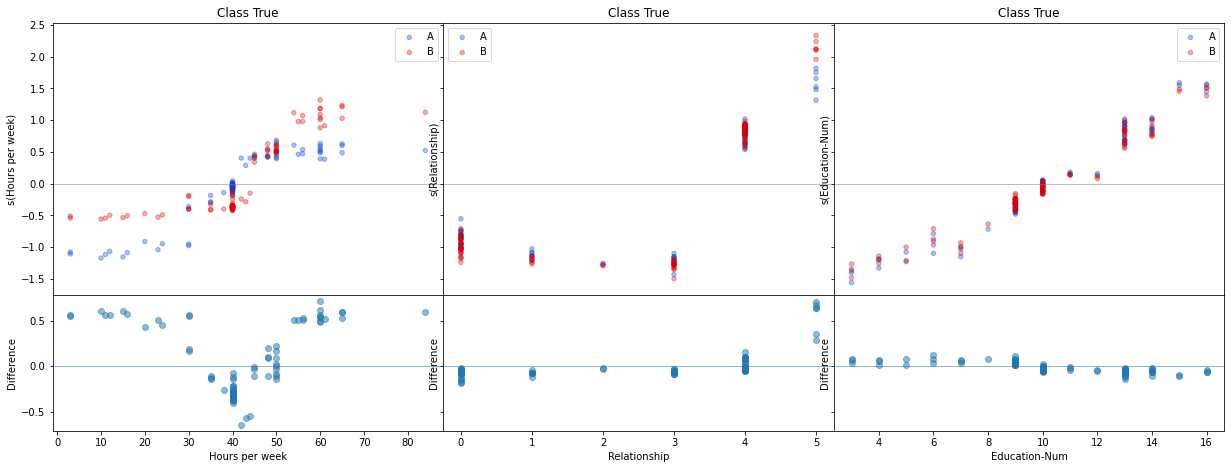

In [170]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex='col', sharey='row', squeeze=False,
                        figsize=(3 * 7, 1.5 * 5), gridspec_kw={'height_ratios': [2,1]})
feature_it = iter(feature_names[feature_order])
compare_indiv_dep_plots(node, next(feature_it), fig=fig, axs=axs.T[0:1].T)
compare_indiv_dep_plots(node, next(feature_it), fig=fig, axs=axs.T[1:2].T)
compare_indiv_dep_plots(node, next(feature_it), fig=fig, axs=axs.T[2:3].T)
plt.savefig('figures/adult-indiv-depplots.pdf', bbox_inches='tight')

Moving B by -10 hours and -0.6 log odds places one curve above the other.

<AxesSubplot:>

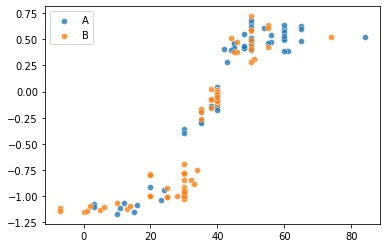

In [122]:
s = indiv_shap_values[:, 'Hours per week']
sns.scatterplot(x=s.data, y=s[:, 'A.True'].values, label='A', alpha=0.8)
sns.scatterplot(x=s.data - 10, y=s[:, 'B.True'].values - 0.6, label='B', alpha=0.8)

In [17]:
root = load('(True, False)')

In [18]:
classes = ['(False, False)', '(True, False)', '(True, True)']

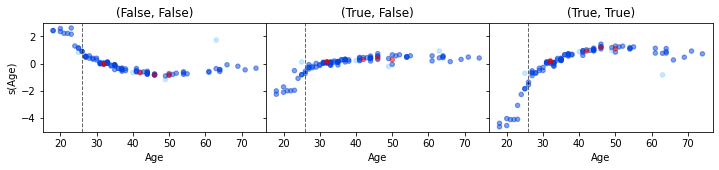

In [25]:
node = root.get('R')
node.root.plot_feature_dependence('Age', classes=classes, focus=node, alpha=0.5, figsize=(4, 2), show=False)
plt.savefig('figures/adult-global-depplots-10-age.pdf', bbox_inches='tight')

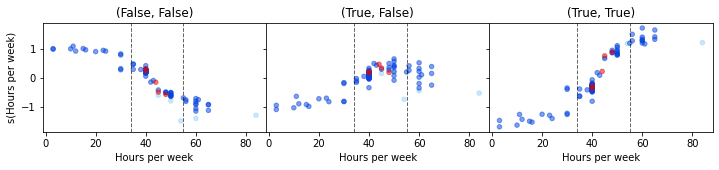

In [26]:
node = root.get('R')
node.root.plot_feature_dependence('Hours per week', classes=classes, focus=node, alpha=0.5, figsize=(4, 2), show=False)
plt.savefig('figures/adult-global-depplots-10-hours.pdf', bbox_inches='tight')

In [21]:
nodes = dict([(name, root.get(cluster)) for name, cluster in
              [
                  ('Main Node', ''),
                  ('Node 1', 'RLR'),
                  ('Node 2', 'RLL')
              ]
             ])

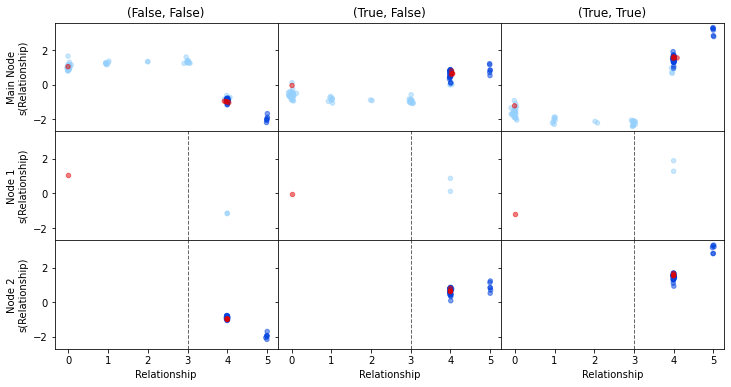

In [22]:
plot_joint_feature_dependence('Relationship', classes, with_context=True, **nodes)
plt.savefig('figures/adult-depplots-10-relationship.pdf', bbox_inches='tight')

In [23]:
nodes = dict([(name, root.get(cluster)) for name, cluster in
              [
                  ('Main Node', ''),
                  ('Node 1', 'RLR'),
                  ('Node 2.1', 'RLLR'),
                  ('Node 2.2', 'RLLL')
              ]
             ])

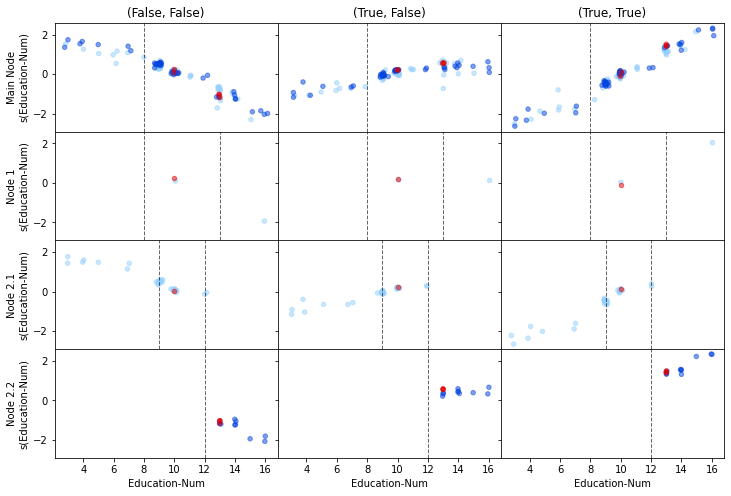

In [24]:
plot_joint_feature_dependence('Education-Num', classes, with_context=True, **nodes)
plt.savefig('figures/adult-depplots-10-education.pdf', bbox_inches='tight')

In [15]:
nodes = dict([(name, root.get(cluster)) for name, cluster in
              [
                  ('Main Node', ''),
                  ('Node 1', 'RLR'),
                  ('Node 2', 'RLL'),
                  ('Node 2.1', 'RLLR'),
                  ('Node 2.2', 'RLLL')
              ]
             ])

In [16]:
for name, node in nodes.items():
    rule = node.rule_from_counterfactuals(order=feature_order, latex=True)[0]
    print(f'\item \emph{{{name}}}: ${rule}$')

\item \emph{Main Node}: $34 < \text{Hours per week} \leq 54 \land \text{Education-Num} > 8 \land \text{Age} > 26 \land \text{Capital Gain} \leq 56$
\item \emph{Node 1}: $34 < \text{Hours per week} \leq 44 \land \text{Relationship} \leq 2 \land 8 < \text{Education-Num} \leq 12 \land \text{Age} > 35 \land 2 < \text{Occupation} \leq 4 \land \text{Capital Gain} \leq 56 \land \text{Capital Loss} > 2384 \land \text{Sex} \leq 0$
\item \emph{Node 2}: $34 < \text{Hours per week} \leq 54 \land \text{Relationship} > 3 \land \text{Education-Num} > 9 \land \text{Age} > 26 \land \text{Capital Gain} \leq 56 \land \text{Capital Loss} \leq 1447$
\item \emph{Node 2.1}: $44 < \text{Hours per week} \leq 54 \land \text{Relationship} > 3 \land 9 < \text{Education-Num} \leq 11 \land 44 < \text{Age} \leq 59 \land \text{Occupation} > 13 \land \text{Capital Gain} \leq 56 \land \text{Capital Loss} \leq 1447 \land 1 < \text{Workclass} \leq 5 \land \text{Sex} > 0 \land \text{Marital Status} \leq 2 \land \text{Coun

In [133]:
from clustering import eval_clusterings_for_class

In [136]:
nodes = [root.get(cluster) for cluster in ['RLR', 'RLLR', 'RLLL']]
eval_clusterings_for_class('(True, False)', nodes, X_test, shap_values_test)

Precision           0.565611
Recall               0.52521
F1 Score            0.544662
Support                238.0
Label          (True, False)
Nodes                      3
Constraints               34
Name: True, dtype: object